In [1]:
import pandas as pd
from tqdm import tqdm
import os
import openai
import numpy as np
import pickle as pk
import seaborn as sns
import matplotlib.pyplot as plt
import json
from brokenaxes import brokenaxes
from sklearn.manifold import TSNE
from tqdm import tqdm
# keys = json.load(open("keys.json"))
# os.environ["OPENAI_API_KEY"]=keys["OPENAI_API_KEY"]
# openai.api_key = os.environ.get("OPENAI_API_KEY")
# import together
# os.environ["TOGETHER_API_KEY"]=keys["TOGETHER_API_KEY"]
# together.api_key = os.environ.get("TOGETHER_API_KEY")
# pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('future.no_silent_downcasting', True)
from scipy.stats import chisquare, sem
plt.rcParams.update({
    "axes.facecolor": "white",                      # background stays white
    "axes.edgecolor": "black",                      # keep axis edges
    "patch.facecolor": "lightcoral",
    "text.usetex": False,                           # render text with LaTeX
    "font.family": "sans-serif",                    # use serif fonts
    "axes.spines.top": False,                       # remove top border
    "axes.spines.right": False,                     # remove right border
    "axes.labelsize": 16,                           # bigger axis labels
    "xtick.labelsize": 14,                          # bigger x-tick labels
    "ytick.labelsize": 14,                          # bigger y-tick labels
    "axes.titlesize": 18,                           # bigger title
    "figure.dpi": 100,                              # higher resolution
})
from mpl_toolkits.mplot3d import Axes3D  # activates 3D projection
print("hi")

hi


In [2]:
import numpy as np
from scipy import stats
res = stats.spearmanr([
  1.1580507, 0.066552, 0.15002869, 0.12491651, 0.50153756, 0.4646486,
  0.03276786, 0.6010311, 0.79835117, 0.17289853, -0.15135707, 0.61203575,
  0.7781848, 0.02536051, -0.07856986, 0.0549242, 0.02384605, -0.02910639,
  0.03493351, 0.19123204, -0.05259304, 0.08858683, 0.11527813, 0.14396,
  0.07731297, -0.66851664, -0.07858647, 0.04621653, 0.22485556, 0.15002869,
  -0.11783456, 0.1686158, -0.02257443, 0.22341302, -0.02752743, 0.2625989,
  1.0301206, 0.00537847, -0.13365363, 0.185491, 0.17862962, 0.12753233,
  -0.16732693, -0.00957566, -0.14719708, 0.1356208, 0.11857465, 0.04137856,
  0.23021367, 0.37945804, 0.63501996, -0.02282515, 0.26294622, 0.2020318,
  0.14207482, -0.03154175, 0.0965078, 0.04651363, -0.01554856, 0.07699603,
  -0.25729716, 0.22635578, 0.20745762, -0.15078925, 0.27794722, 0.22197317,
  0.0220029, 0.21577607, -0.01638547, -0.06082735, 0.11514991, -0.02682037,
  0.24092402, 0.0509807, 0.29014394, 0.3170514, 0.1474342, 0.25680888,
  -0.09915292, 0.10866363, 0.38521418, 0.6746649, -0.04486789, 0.09256448,
  0.09188308, 0.04121339, -0.00351273, -0.00684924, -0.09741485, 0.00654446,
  0.15581496, -0.03598781, 0.16000925, 0.0302618, 0.07773, 0.13252752,
  0.18527493, 0.16073628, 0.3530335, -0.02182009, 0.08069973, 0.13580552,
  0.08299359, -0.06750766, -0.07201986, 0.5718461, 0.09996863, -0.3960657,
  0.05393778, 0.34754175, 0.06921431, 0.07340286, 0.02609423, -0.15512504,
  -0.01863477, 0.0195228, 0.19711065, 0.05177296, 0.06562126, 0.0283671,
  0.07755759, 0.10482535, 0.08231503, 0.04983292, 0.02383711, 0.19636773,
  0.26506984, 0.11020374, 0.00301669, -0.03850859, 0.13092853, -0.04770505,
  0.07051668, -0.05927828, 0.1477192, -0.03026943, 0.17311388, 0.17623009,
  -0.03218031, 0.33844858, -0.07766677, -0.02166699, 0.28007072, 0.37346584,
  -0.00587232, 0.67575157, 0.46452212, -0.2557572, -0.54157025, 0.24099968,
  0.30411935, 0.3873901, 0.2799937, 0.219869, 0.15630972, 0.26409063,
  -0.37027508, -0.23646036, -0.25293064, 0.07645313, -0.01491474, -0.21320367,
  0.37175664, -0.6685171, -0.6774641, -0.4304775, 0.14318395, -0.07766677,
  0.44245473, 0.02848186, 0.34545654, -0.04045193, 0.43116635, -0.5424605,
  0.51363033, 0.42576542, 0.02953316, -0.14596188, 0.691795, 0.31653142,
  0.7904402, 0.3214874, -0.6007354, 0.5383026, -0.12882365, 0.15980609,
  0.14227541, 0.02892765, -0.10804482, 0.18001588, -0.03116298, 0.30848604,
  -0.15298577, -0.22948225, -0.00501704, 0.4223263, 0.21181339, -0.26086813,
  -0.05800282, 0.11817957, 0.94055045, 0.25821707, 0.29894063, 0.3418922,
  0.05526873, -0.29937133, -0.2576614, 0.30290988, -0.34574243, 0.21302362,
  -0.39774117, -0.70628226, -0.21065642, 0.22367957, 0.27424657, -0.09583478,
  0.21845773, 0.35433283, -0.20297682, 0.44000757, -0.08162612, -0.18823823,
  0.19776697, 0.11883362, -0.04506757, 0.29694948, 0.17870554, -0.35416117,
  -0.31016517, 0.05436027, 1.0310941, 0.16865107, -0.903157, 0.4812503,
  -0.19584571, 0.17977235, -0.09362502, 0.03269472, -0.07100697, -0.21684028,
  -0.01430975, -0.07024553, 0.04779949, 0.71499205, -0.16509095, 0.39607492,
  -0.07400755, 0.88061047, 0.30820328, 0.00145134, 0.08355403, -0.3034132,
  -0.3066935, 0.6282013, -0.09907807, -0.01995344, -0.22855847, 0.2761869,
  -0.17401811, 0.26420203, -0.7447636, 0.55518275, 0.11356897, 0.15456748,
  0.35075888, -0.1795154, -0.04036535, 0.02133798, 0.2914487, 0.12546548,
  -0.11387607, -0.01981103, -0.31187755, -0.13924871, -0.14790551, 0.6950596,
  -0.318596], [ 1.2177e+00,  5.2574e-02,  2.0691e-01,  7.7909e-02,  5.8386e-01,
         7.5381e-01,  1.2244e-01,  6.5246e-01,  8.7809e-01,  5.9232e-03,
        -1.8068e-02,  6.5317e-01,  8.7080e-01,  2.0773e-02, -1.1789e-01,
         1.1105e-01,  1.0918e-02, -6.9095e-02,  4.7445e-02,  1.8493e-01,
         3.0293e-02, -7.8805e-03,  7.1707e-02,  1.6109e-01,  7.3488e-01,
        -2.5816e+00, -1.1290e-01,  7.9168e-02,  2.0109e-01,  2.0691e-01,
        -1.0174e-01, -3.9501e-02, -6.3240e-02,  2.0763e-01,  1.3497e-02,
         2.5860e-01,  1.0808e+00,  1.7532e-01, -2.9210e-01,  2.4286e-01,
         1.6367e-01,  1.4450e-01, -1.5695e-01,  5.7041e-02, -1.4699e-01,
         1.8240e-01,  1.0194e-01,  3.8402e-02,  2.0835e-01,  6.5108e-01,
         9.8582e-01,  1.8808e-02,  4.1869e-01,  2.7516e-01,  1.3322e-01,
        -3.9467e-02,  9.4672e-02,  9.0696e-02, -3.1064e-02,  1.1669e-01,
        -2.1390e-01,  2.1139e-01,  2.2220e-01, -1.1258e-01,  2.6631e-01,
         2.1709e-01,  4.6156e-02,  2.3443e-01,  1.0973e-02, -5.0720e-02,
         1.4442e-01, -8.4203e-03,  2.4668e-01,  8.1504e-02,  2.7228e-01,
         3.3234e-01,  1.3382e-01,  2.2149e-01, -1.4794e-01,  1.6788e-01,
         4.4645e-01,  6.6848e-01, -9.7567e-03,  1.1359e-01,  1.1761e-01,
         6.0601e-02,  1.8856e-02,  9.4752e-03, -6.3905e-02,  9.4476e-02,
         1.7318e-01,  9.2187e-03,  2.7042e-01,  2.8692e-02,  1.0154e-01,
         1.2040e-01,  1.9320e-01,  1.4716e-01,  4.1904e-01,  6.2614e-02,
         9.9927e-02,  1.0769e-01,  6.9961e-02, -2.7831e-01, -1.5791e-01,
         9.2957e-01,  3.7885e-02,  2.3824e-01,  2.8561e-03,  3.6763e-01,
         6.0534e-02,  7.3076e-02,  2.9031e-02, -2.0133e-01, -7.9010e-01,
         6.7771e-02,  2.6188e-01,  6.1086e-02,  6.3032e-02,  3.0310e-02,
         9.6690e-02,  9.2967e-02,  6.8943e-02,  9.0438e-03, -1.8403e-02,
         1.8849e-01,  2.0906e-01,  7.3553e-02,  1.8591e-02,  1.7406e-02,
         1.6709e-01, -2.7976e-02,  6.4591e-02, -6.4864e-02,  1.3947e-01,
        -1.7043e-02,  1.7007e-01,  2.0168e-01, -8.4742e-02,  2.9896e+00,
         7.6335e-01, -1.7611e+00,  3.0184e+00,  3.6346e+00,  2.9983e+00,
         9.6362e-01,  1.2018e+00, -1.3062e+00, -1.3769e+00,  6.3828e-01,
         1.9903e-01,  5.5710e-01,  4.3116e-01,  3.6188e-01,  2.2746e-01,
         1.6634e-01, -4.9325e-01, -2.4451e-01, -2.0677e-01,  7.5131e-01,
        -1.7167e-01, -3.7987e-01,  2.2863e+00, -2.5829e+00, -6.9011e-01,
        -4.7591e-01,  2.8120e-01,  7.6335e-01,  6.4544e-01,  1.1360e-01,
         5.8384e-01, -2.3332e-01,  5.8058e-01, -2.3776e-01,  6.0398e-01,
         4.8580e-01,  8.9983e-01, -3.2498e-01,  1.2267e+00,  1.3414e+00,
         1.6912e+00,  6.1602e-01, -6.8303e-01,  4.9978e-01,  5.2183e-02,
         4.7443e-01,  2.1893e-01,  4.1458e-02,  6.4964e-01,  2.4672e-01,
        -3.8888e-01,  2.8057e-01, -1.9691e-01, -1.3606e-01, -3.9673e-02,
         3.3402e-01,  6.3802e-01, -3.0997e-01, -3.5222e-01,  4.3983e-02,
         9.3503e-01,  7.3512e-02,  5.8664e-01,  3.9915e-01,  2.1116e-02,
        -3.2053e-01, -1.9446e-01,  4.3154e-01, -4.5954e-01,  5.1017e-01,
        -5.1193e-01, -8.5005e-01, -2.1842e-01,  1.7095e-01,  2.0430e-01,
         3.6688e-02, -2.2384e-01,  1.0872e-01, -2.5344e-01,  6.3886e-01,
        -7.7928e-02,  4.8087e-02,  2.4898e-01,  3.0565e-02, -1.2778e-01,
         3.2667e-03,  1.6276e-01, -5.0161e-01, -1.8908e-01,  6.3838e-02,
         1.5808e+00,  2.8004e-01, -9.4456e-01,  4.5628e-01, -9.1751e-02,
         6.2631e-02, -8.1940e-02, -1.8854e-01, -2.0044e-01, -3.3221e-01,
        -1.6646e-01, -1.8494e+00,  9.5229e-01,  1.5170e+00,  1.5935e-01,
         1.7627e+00, -8.7813e-01,  8.0516e-01,  3.8076e-01,  4.6237e-02,
         2.3521e-01, -6.7211e-01, -1.3051e+00,  7.5715e-01,  3.1887e-02,
        -1.2255e-01, -3.7634e-01,  2.1352e-01, -2.4031e-01,  7.2117e-02,
        -5.6895e-01,  6.1831e-01,  1.3669e-02,  1.4805e-02,  5.0719e-01,
        -2.2781e-01,  4.1483e-02, -2.6503e-01,  3.4719e-01,  6.4745e-01,
        -6.9564e-01,  1.2456e-01, -1.8082e-01, -3.3121e-01, -1.2321e-01,
         8.5364e-01, -1.5340e-01]
)
res

SignificanceResult(statistic=0.8510708093162753, pvalue=6.407844692624839e-79)

In [3]:
data2 = pd.read_csv("../csvs/hills.csv")
data2 = data2[~data2["response"].isin(["mammal", "bacterium", "unicorn", "woollymammoth"])].reset_index(drop=True)
data2["previous_response"] = data2.groupby("pid")["response"].shift(1)
data2["order"] = data2.groupby("pid").cumcount() + 1

data3 = pd.read_csv("../csvs/noconstraints.csv")
data4 = pd.read_csv("../csvs/similar.csv")
data5 = pd.read_csv("../csvs/divergent.csv")

In [ ]:
RT_analysis = pd.read_csv("../csvs/RT_analysis.csv")

In [ ]:
cols = [
    'freq', 'HS', 'activity', 'logRT', 'logPrej', 'chosen',
    'pid', 'trial', 'patchnum', 'numwithinpatch', 'switchornot',
    'cue_transitions', 'patchnum2', 'numwithinpatch2'
]

corr = RT_analysis[cols].corr()

# mask upper triangle + diagonal
mask = np.triu(np.ones_like(corr, dtype=bool), k=0)

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    mask=mask,
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    annot=True,
    fmt=".2f",
    annot_kws={"size": 9},
)

# plt.title("Correlation Heatmap (Lower Triangle)")
plt.tight_layout()
plt.show()

In [ ]:
data2["fpatchitem"].mean()

In [ ]:
data2 = data2.drop(columns=["fpatchnum", "fpatchitem", "fitemsfromend", "flastitem",  "meanirt", "catitem"])

In [ ]:
data2.to_csv("../csvs/hills_removecols.csv", index=False)

In [ ]:
from scipy.stats import entropy
LLM = [-0.9255,  0.5204, -1.6303,  0.2473,  1.8285,  0.4606,  1.2766,
         0.9898,  0.4488, -0.4499,  0.9888,  0.1349,  0.2244,  0.2634,  0.0105,
        -0.0853,  0.0293,  0.0956,  0.1151, -1.7363,  1.4970, -0.1477,  0.2745,
         1.0074,  1.0074, -0.2799,  0.0395,  0.7450,  0.5204, -0.2911, -1.5390,
        -0.4192,  0.3429,  0.0236,  0.1685,  1.2109,  0.0479,  0.6305, -0.3033,
         0.4523, -0.1821,  2.4305, -0.1727, -0.0441,  0.4466, -0.6810, -0.0246,
         0.8417,  1.5777,  2.0010, -0.6070,  0.1164,  0.3162, -0.1183, -0.1200,
        -0.3759, -0.0985,  2.3146,  0.3572,  0.3372, -1.1479, -0.4176,  0.6292,
         0.2064,  0.7692,  0.0851,  1.0894,  0.5365,  0.3604,  0.4378,  0.4105,
         0.3604,  0.2523,  1.4086,  0.5277, -0.0730, -0.1788,  0.7516,  0.6652,
         0.9830,  1.8034,  0.0078, -0.2328,  0.2395, -0.0550,  0.5279,  0.2868,
         1.8565, -0.4671,  0.5954, -0.2804,  0.0979, -0.0621,  0.0189,  0.0356,
         0.3746,  0.7372,  0.0051,  0.1424, -0.0785,  0.3206, -0.0058,  0.9527,
        -2.1665, -0.4393,  0.5472, -1.8019,  0.7446,  0.2837,  0.4872,  0.3876,
         0.0418, -0.4765, -0.6500,  0.4242,  0.1756,  0.1551, -0.2118,  0.0531,
        -0.0662,  0.2928,  0.2596,  0.2032,  0.5794,  0.0813, -0.6023, -0.0997,
        -0.0694, -0.0637,  0.0864,  0.8803, -1.9425,  0.1074,  0.2726,  0.5413,
         0.0674,  0.7408, -0.4525]
human = [-0.0138,  0.2288,  0.0713,  0.2251,  0.4985, -0.0537,  0.3645,
         0.8561,  0.0238, -0.2880,  0.4157,  0.8518,  0.1569, -0.0027,  0.0396,
         0.0630, -0.1624,  0.0649,  0.1641,  0.0206,  0.0017,  0.0838, -0.0555,
         0.5559, -0.7895, -0.0076,  0.0017,  0.2628,  0.2288, -0.0541,  0.1251,
        -0.1686,  0.2309,  0.0779,  0.5883,  1.0658, -0.1096, -0.3396,  0.1288,
         0.0763,  0.1391, -0.2139, -0.0767,  0.1378, -0.2801,  0.1341,  0.0270,
         0.0579,  0.5069,  0.8559,  0.0077,  0.4070,  0.4237,  0.2192, -0.1268,
         0.1215,  0.0483, -0.1079,  0.0792, -0.6001,  0.0649,  0.0857, -0.1114,
         0.3703,  0.1707,  0.0384,  0.2559, -0.0324, -0.0618,  0.1994, -0.0444,
         0.3105,  0.0272,  0.2003,  0.3637,  0.0885,  0.2255, -0.2400,  0.3229,
         0.3821,  0.6627, -0.0209,  0.1115,  0.0705,  0.0733,  0.0584, -0.2636,
         0.2422, -0.0185,  0.3026, -0.0936, -0.0978, -0.0480,  0.1836,  0.2017,
         0.2223,  0.3732,  0.3546,  0.0788,  0.2831,  0.1905,  0.0489, -0.2282,
         0.0266,  0.4614,  0.0873, -1.4220,  0.2816,  0.2110,  0.0814,  0.1245,
         0.0292, -0.4524, -0.5090,  0.2836, -0.0463,  0.0966,  0.1732,  0.0613,
        -0.0064, -0.1436,  0.1286,  0.6397,  0.1939,  0.1482,  0.1542,  0.0967,
         0.0611, -0.1571,  0.5137, -0.3009,  0.0859, -0.0212,  0.0628,  0.0014,
         0.1840,  0.2051,  0.0435]
arr = np.array(LLM)  # uses natural log (nats)
p = np.exp(arr - arr.max())  # stable softmax
p = p / p.sum()
H = entropy(p)  # natural log
print(H)

print(np.var(human), np.var(LLM))

In [ ]:
plt.hist(human)
plt.hist(LLM, alpha=0.3)

In [ ]:
res = stats.spearmanr([-2.9148e-01,  2.4424e-01, -8.1303e+00,  6.9032e-01,
         3.6365e+00, -1.3209e-01,  7.3872e-01,  1.1487e+00,  2.1078e-01,
         5.6577e-02,  1.1454e+00,  2.1946e-01,  1.5408e-01,  2.1686e-01,
        -1.8729e-02, -5.5054e-02,  8.5510e-03,  9.8847e-02,  1.7395e-01,
        -2.2743e+00,  1.8172e+00,  1.5081e-02,  5.0679e-01,  9.9867e-01,
         9.9867e-01, -1.7719e-03,  1.2513e-02,  2.5924e-01,  2.4424e-01,
        -4.7581e-01, -1.6835e-01,  2.5619e-02,  2.8401e-01, -1.7529e-01,
         1.1855e-01,  1.9490e+00, -9.7991e-01,  6.1161e-01,  6.6150e-01,
         6.7946e-01, -4.2616e-01,  1.4136e+00, -2.7602e-01,  2.5224e-01,
         3.7179e-01, -1.6605e-01,  3.7538e-01,  9.0639e-01,  3.0909e-01,
         2.0503e+00, -9.5320e-02,  4.3919e-01,  2.1470e-01, -1.0550e-01,
        -3.7236e-02, -2.8967e-01, -1.9098e-01,  2.1405e+00,  4.0118e-01,
         1.5765e+00, -2.7593e-01, -1.2068e-02,  6.3690e-01, -1.4508e-01,
         6.9140e-01,  1.1684e-01,  1.0625e+00,  6.0810e-01,  2.3132e-01,
         2.0299e-01,  4.4889e-01,  2.7036e-01,  2.6660e-01,  8.7229e-01,
         5.7886e-01,  1.2424e-01, -1.2302e-01,  1.4509e+00, -6.7067e-02,
         1.0750e+00,  1.2604e+00,  3.7675e-01, -2.0247e-01,  2.1191e-01,
        -2.7192e-01,  1.2195e-02,  4.3884e-01,  1.2436e+00, -1.4545e-01,
         5.9411e-01, -3.0505e-01,  7.9493e-01, -8.1727e-03,  8.0294e-02,
         1.8077e-01,  8.5342e-02,  1.1285e+00,  7.3788e-01, -1.9714e-01,
        -1.6419e-01,  2.5797e-01,  8.1629e-01,  1.8285e+00, -1.1435e+00,
         1.1652e+00,  7.6730e-01, -1.2892e+00,  1.3580e-02, -3.5733e-04,
         4.0742e-01,  4.4426e-01,  1.1893e-01, -7.4854e-01, -3.2908e+00,
        -3.1833e-01, -1.8794e-01,  1.8743e-01, -6.2901e-01, -2.2365e-01,
         1.4992e-01,  3.4905e-01,  2.0200e-01, -1.9455e+00,  5.5240e-01,
         6.4667e-02, -1.1275e-01, -1.0322e-01, -1.5200e-02, -7.2125e-01,
         2.4674e-01,  6.0785e-01, -1.6238e+00,  2.4725e-01,  3.0446e-01,
        -1.8557e-01, -3.8663e-01,  6.3399e-01, -8.8990e-01,  2.1706e+00,
         9.3075e-02, -1.0056e+00, -7.1388e+00, -2.0379e+00, -3.6679e+00,
        -2.5143e+00,  2.4238e+00, -2.6246e+00, -2.8871e+00, -3.4656e+00,
        -1.6324e+00,  6.7901e-01, -6.1342e-01,  2.1201e-01, -9.1141e-02,
         2.0529e+00, -1.2509e-01, -9.7123e-01, -1.7653e+00,  7.5115e+00,
         6.1623e-01, -5.3890e-01,  1.0000e+00,  1.0018e+00, -9.4627e-01,
        -7.5666e-03,  8.4654e-02,  9.3075e-02, -1.1409e+00, -3.3363e+00,
         4.9693e-01, -7.7543e-01,  1.2678e+00, -4.1524e+00, -1.7546e+00,
        -2.8846e+00,  3.1121e+00,  1.3347e-01,  2.2567e+00, -1.8985e+00,
         7.9853e+00, -3.9650e-01,  1.2713e+00, -8.7645e-02,  1.2980e+00,
        -3.6895e+00,  1.8473e+00, -2.9226e+00, -5.3246e+00, -9.7876e-01,
        -2.2369e+00, -7.8690e-01,  1.0412e+00, -5.2993e-01, -1.3671e+00,
         1.0942e+00, -1.5030e+01,  4.0659e-01,  8.9422e-01, -1.3451e+00,
         8.7263e-01,  1.9400e+00,  5.9422e-01,  7.1105e-01,  1.0719e+00,
         1.3063e+00, -2.0613e-01,  9.4034e-01,  6.0888e-01, -1.2416e+00,
         1.3315e+00, -5.5893e-01, -9.6736e-01,  2.9846e-01,  9.7265e-01,
        -8.1761e-01,  8.4811e-01, -1.7651e+00, -5.4309e+00, -1.0776e+00,
         1.4252e+00, -1.5209e+00, -3.0753e-01, -1.7989e+00, -2.8663e+00,
        -6.6442e-02,  4.7052e+00, -1.0575e+00, -2.0733e-01,  9.8709e-01,
         4.2006e+00, -7.5948e-01, -1.6393e+00, -3.6260e-01, -1.5854e+00,
         1.3462e+00, -5.0698e-01, -4.7515e-02,  4.1168e-02, -1.6100e+00,
        -1.3112e+00,  7.1733e+00,  1.6045e+00, -3.2416e+00, -2.6234e+00,
        -1.3672e-01, -3.3525e+00,  2.3354e+00, -6.0989e-01,  1.8492e+00,
         1.6289e+00, -5.5372e-01, -2.6225e+00,  1.6587e+00, -2.9327e+00,
         1.4169e+00, -1.8154e+00,  2.9959e+00,  1.7145e+00,  2.0041e+00,
        -3.4359e+00, -9.0674e-01,  9.0206e-02, -1.7712e+00, -9.4995e-01,
         3.8847e-01, -1.3289e-01,  1.3356e+00, -1.1158e+00, -1.8713e+00,
         1.0795e+01, -4.7507e-01, -1.2621e+00, -1.2111e+00,  5.8322e-01,
         4.5307e-02, -4.2930e+00], [5.2574e-02,  2.0691e-01,  7.7909e-02,  5.8386e-01,
         7.5381e-01,  1.2244e-01,  6.5246e-01,  8.7809e-01,  5.9232e-03,
        -1.8068e-02,  6.5317e-01,  8.7080e-01,  2.0773e-02, -1.1789e-01,
         1.1105e-01,  1.0918e-02, -6.9095e-02,  4.7445e-02,  1.8493e-01,
         3.0293e-02, -7.8805e-03,  7.1707e-02,  1.6109e-01,  7.3488e-01,
        -2.5816e+00, -1.1290e-01,  7.9168e-02,  2.0109e-01,  2.0691e-01,
        -1.0174e-01, -3.9501e-02, -6.3240e-02,  2.0763e-01,  1.3497e-02,
         2.5860e-01,  1.0808e+00,  1.7532e-01, -2.9210e-01,  2.4286e-01,
         1.6367e-01,  1.4450e-01, -1.5695e-01,  5.7041e-02, -1.4699e-01,
         1.8240e-01,  1.0194e-01,  3.8402e-02,  2.0835e-01,  6.5108e-01,
         9.8582e-01,  1.8808e-02,  4.1869e-01,  2.7516e-01,  1.3322e-01,
        -3.9467e-02,  9.4672e-02,  9.0696e-02, -3.1064e-02,  1.1669e-01,
        -2.1390e-01,  2.1139e-01,  2.2220e-01, -1.1258e-01,  2.6631e-01,
         2.1709e-01,  4.6156e-02,  2.3443e-01,  1.0973e-02, -5.0720e-02,
         1.4442e-01, -8.4203e-03,  2.4668e-01,  8.1504e-02,  2.7228e-01,
         3.3234e-01,  1.3382e-01,  2.2149e-01, -1.4794e-01,  1.6788e-01,
         4.4645e-01,  6.6848e-01, -9.7567e-03,  1.1359e-01,  1.1761e-01,
         6.0601e-02,  1.8856e-02,  9.4752e-03, -6.3905e-02,  9.4476e-02,
         1.7318e-01,  9.2187e-03,  2.7042e-01,  2.8692e-02,  1.0154e-01,
         1.2040e-01,  1.9320e-01,  1.4716e-01,  4.1904e-01,  6.2614e-02,
         9.9927e-02,  1.0769e-01,  6.9961e-02, -2.7831e-01, -1.5791e-01,
         9.2957e-01,  3.7885e-02,  2.3824e-01,  2.8561e-03,  3.6763e-01,
         6.0534e-02,  7.3076e-02,  2.9031e-02, -2.0133e-01, -7.9010e-01,
         6.7771e-02,  2.6188e-01,  6.1086e-02,  6.3032e-02,  3.0310e-02,
         9.6690e-02,  9.2967e-02,  6.8943e-02,  9.0438e-03, -1.8403e-02,
         1.8849e-01,  2.0906e-01,  7.3553e-02,  1.8591e-02,  1.7406e-02,
         1.6709e-01, -2.7976e-02,  6.4591e-02, -6.4864e-02,  1.3947e-01,
        -1.7043e-02,  1.7007e-01,  2.0168e-01, -8.4742e-02,  2.9896e+00,
         7.6335e-01, -1.7611e+00,  3.0184e+00,  3.6346e+00,  2.9983e+00,
         9.6362e-01,  1.2018e+00, -1.3062e+00, -1.3769e+00,  6.3828e-01,
         1.9903e-01,  5.5710e-01,  4.3116e-01,  3.6188e-01,  2.2746e-01,
         1.6634e-01, -4.9325e-01, -2.4451e-01, -2.0677e-01,  7.5131e-01,
        -1.7167e-01, -3.7987e-01,  2.2863e+00, -2.5829e+00, -6.9011e-01,
        -4.7591e-01,  2.8120e-01,  7.6335e-01,  6.4544e-01,  1.1360e-01,
         5.8384e-01, -2.3332e-01,  5.8058e-01, -2.3776e-01,  6.0398e-01,
         4.8580e-01,  8.9983e-01, -3.2498e-01,  1.2267e+00,  1.3414e+00,
         1.6912e+00,  6.1602e-01, -6.8303e-01,  4.9978e-01,  5.2183e-02,
         4.7443e-01,  2.1893e-01,  4.1458e-02,  6.4964e-01,  2.4672e-01,
        -3.8888e-01,  2.8057e-01, -1.9691e-01, -1.3606e-01, -3.9673e-02,
         3.3402e-01,  6.3802e-01, -3.0997e-01, -3.5222e-01,  4.3983e-02,
         9.3503e-01,  7.3512e-02,  5.8664e-01,  3.9915e-01,  2.1116e-02,
        -3.2053e-01, -1.9446e-01,  4.3154e-01, -4.5954e-01,  5.1017e-01,
        -5.1193e-01, -8.5005e-01, -2.1842e-01,  1.7095e-01,  2.0430e-01,
         3.6688e-02, -2.2384e-01,  1.0872e-01, -2.5344e-01,  6.3886e-01,
        -7.7928e-02,  4.8087e-02,  2.4898e-01,  3.0565e-02, -1.2778e-01,
         3.2667e-03,  1.6276e-01, -5.0161e-01, -1.8908e-01,  6.3838e-02,
         1.5808e+00,  2.8004e-01, -9.4456e-01,  4.5628e-01, -9.1751e-02,
         6.2631e-02, -8.1940e-02, -1.8854e-01, -2.0044e-01, -3.3221e-01,
        -1.6646e-01, -1.8494e+00,  9.5229e-01,  1.5170e+00,  1.5935e-01,
         1.7627e+00, -8.7813e-01,  8.0516e-01,  3.8076e-01,  4.6237e-02,
         2.3521e-01, -6.7211e-01, -1.3051e+00,  7.5715e-01,  3.1887e-02,
        -1.2255e-01, -3.7634e-01,  2.1352e-01, -2.4031e-01,  7.2117e-02,
        -5.6895e-01,  6.1831e-01,  1.3669e-02,  1.4805e-02,  5.0719e-01,
        -2.2781e-01,  4.1483e-02, -2.6503e-01,  3.4719e-01,  6.4745e-01,
        -6.9564e-01,  1.2456e-01, -1.8082e-01, -3.3121e-01, -1.2321e-01,
         8.5364e-01, -1.5340e-01])
res

## Analyse features

In [4]:
def get_featuredf():
    featuredict = pk.load(open(f"../files/features_gpt41.pk", "rb"))
    featuredf = pd.DataFrame.from_dict(featuredict, orient='index')
    featuredf = featuredf.replace({True: 1, False: 0, 'True': 1, 'True.': 1, 'TRUE': 1, 'true': 1, 'False': 0, 'False.': 0, 'false': 0})
    featuredf = featuredf[featuredf.applymap(lambda x: isinstance(x, int)).all(axis=1)]
    return featuredf, featuredf.columns.tolist()

vf_featuredf, vf_featurecols = get_featuredf()

/tmp/ipykernel_3340836/2198514859.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  featuredf = featuredf[featuredf.applymap(lambda x: isinstance(x, int)).all(axis=1)]


In [ ]:
# hills = pd.read_csv("../csvs/hills.csv")
# hills = hills.drop(columns=["fpatchnum", "fpatchitem", "fitemsfromend", "flastitem",  "meanirt", "catitem"])
# hills["previous_response"] = hills.groupby("pid")["response"].shift(1)
# hills["order"] = hills.groupby("pid").cumcount() + 1
# hills = hills[~hills["response"].isin(["mammal", "bacterium", "unicorn", "woollymammoth"])]

# def get_featuredf():
#     featuredict = pk.load(open(f"../files/features_gpt41.pk", "rb"))
#     featuredf = pd.DataFrame.from_dict(featuredict, orient='index')
#     featuredf = featuredf.replace({True: 1, False: 0, 'True': 1, 'True.': 1, 'TRUE': 1, 'true': 1, 'False': 0, 'False.': 0, 'false': 0})
#     featuredf = featuredf[featuredf.applymap(lambda x: isinstance(x, int)).all(axis=1)]
#     return featuredf, featuredf.columns.tolist()
# vf_featuredf, vf_featurecols = get_featuredf()

# valid_animals = set(hills["response"].unique())
# X_df = vf_featuredf.loc[vf_featuredf.index.intersection(valid_animals)].sort_index()
# X_df = vf_featuredf
# X_df[X_df["feature_Is monotreme"] == 1][["feature_Gives birth", "feature_Is monotreme"]]

In [ ]:
# m = X_df["feature_Has feathers"]  # adjust exact column name
# f = X_df["feature_Is a flagship species (conservation symbol)"]

# violations = X_df[(f == 1)]
# violations

In [ ]:
np.array(vf_featurecols)[np.argsort(LLM)[:10]]

In [ ]:
np.array(vf_featurecols)[np.argsort(human)[:10]]

In [ ]:
vf_featuredf[vf_featuredf["feature_Is a flagship species (conservation symbol)"] == 1]["feature_Is a flagship species (conservation symbol)"]

In [ ]:
def correlation_matrix(df):
    correlation_matrix = df.corr()
    mask = np.triu(np.ones(correlation_matrix.shape), k=1)  # Upper triangle mask
    corr = correlation_matrix.where(mask == 0)
    plt.figure(figsize=(15, 10))
    sns.heatmap(corr, annot=False, cmap='RdBu', fmt=".1f", mask=np.triu(np.ones_like(corr, dtype=bool)), vmin=-1, vmax=1)
    plt.show()
    return correlation_matrix

vf_featuredf_corr = correlation_matrix(vf_featuredf)

print(np.mean(vf_featuredf_corr > 0.5))         # % of correlated features (greater than 0.5 corr)
print(np.mean(vf_featuredf_corr < -0.5))        # % of correlated features (less than -0.5 corr)

In [ ]:
vf_featuredf_corr["feature_Is insect"].to_dict()["feature_Has segmented body"]

In [ ]:
def get_highly_correlated_columns(corr, threshold=0.65):
    highly_correlated = {}
    # can change the logic to only keep correlated columns that as least correlated with others
    # if (np.sum(vf_featuredf_corr.loc["feature_Is mammal"].values) - 1)/(len(vf_featuredf_corr.loc["feature_Is mammal"].values) - 1)
    for i, col in enumerate(corr.columns):
        for prev_col in corr.columns[:i]:  # Check only previous columns
            if abs(corr.loc[col, prev_col]) >= threshold:  # Check correlation
                highly_correlated[col] = prev_col
                print(col, prev_col, corr.loc[col, prev_col])
                break
    return highly_correlated

high_corr_columns_vf = get_highly_correlated_columns(vf_featuredf_corr)

## Add features to responses

In [ ]:
data2

In [5]:
def add_features_to_responsedf(df):
    featuredict = vf_featuredf.to_dict(orient='index')
    mapped_features = df['response'].map(featuredict)
    mapped_features = mapped_features.apply(lambda x: x if isinstance(x, dict) else {})
    fc = pd.DataFrame(mapped_features.tolist())
    df = pd.concat([df, fc], axis=1)
    df = df.replace({'True': 1, 'True.': 1, 'False': 0, 'False.': 0})
    dropped_rows = df[df[vf_featurecols].isna().any(axis=1)]
    df = df.dropna(subset=vf_featurecols)
    for col in vf_featurecols:
        df[col] = df[col].astype(int)
    return df, dropped_rows

data2, dropped_rows2 = add_features_to_responsedf(data2)

feature_cols = [col for col in data2.columns if col.startswith('feature_')]

In [ ]:
data2

In [ ]:
def plot_means(df, featuredf, featurecols):
    fig, ax = plt.subplots(1, 2, figsize=(6.5, 3))
    ax[0].hist(featuredf.mean(axis=0).values, color="lightcoral", alpha=0.6);
    ax[0].set_xlabel("P(feat)=1")
    ax[0].set_ylabel("Number of features")
    ax[1].hist(df[featurecols].mean(axis=0).values, color="lightcoral", alpha=0.6);
    ax[1].set_xlabel("P(feat)=1 in responses")
plot_means(data2, vf_featuredf, vf_featurecols)

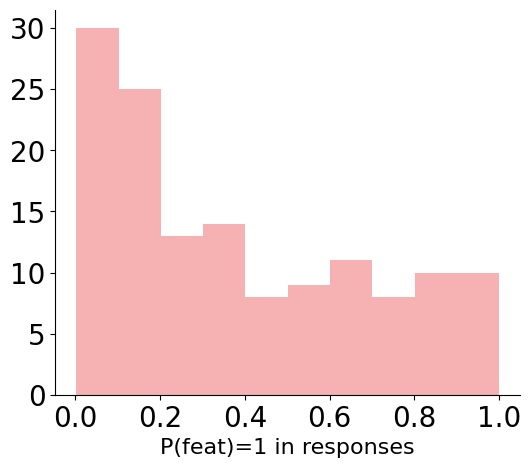

In [10]:
plt.figure(figsize=(6,5))
feature_activities = data2[vf_featurecols].mean(axis=0).values
plt.hist(feature_activities, color="lightcoral", alpha=0.6);
plt.xlabel("P(feat)=1 in responses")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig("../plots/2F.pdf", bbox_inches="tight")

In [ ]:
data2[vf_featurecols].corr().loc[["feature_Is monotreme"]]

## Remove Correlated Columns

In [ ]:
# remove_columns_vf = list(high_corr_columns_vf.keys())
# vf_featuredf = vf_featuredf.drop(columns = remove_columns_vf)
# data2 = data2.drop(columns = remove_columns_vf)
# vf_featurecols = [item for item in vf_featurecols if item not in remove_columns_vf]

# Activity

In [ ]:
percent_active = vf_featuredf.mean() * 100
top5 = percent_active.sort_values(ascending=False).head(10)
bottom5 = percent_active.sort_values().head(10)
combined = pd.concat([top5, bottom5])
plt.figure(figsize=(10, 3.5))
bars = plt.bar(combined.index, combined.values, color="#D8BFD8")
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f"{height:.1f}%", 
             ha='center', va='bottom', fontsize=8)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Percentage Active")
plt.title("Top 5 and Bottom 5 Most Active Features -- UNIFORM")

In [ ]:
percent_active2 = data2[vf_featurecols].mean() * 100
top5 = percent_active2.sort_values(ascending=False).head(10)
bottom5 = percent_active2.sort_values().head(10)
combined = pd.concat([top5, bottom5])
plt.figure(figsize=(10, 6))
bars = plt.bar(combined.index, combined.values, color="#D8BFD8")
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f"{height:.1f}%", 
             ha='center', va='bottom', fontsize=8)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Percentage Active (1)")
plt.title("Top 5 and Bottom 5 Most Active Features -- RESPONSES")
plt.tight_layout()
plt.show()

In [ ]:
percent_diff = percent_active2.subtract(percent_active)
top5 = percent_diff.sort_values(ascending=False).head(10)
bottom5 = percent_diff.sort_values().head(10)
combined = pd.concat([top5, bottom5])
plt.figure(figsize=(10, 6))
bars = plt.bar(combined.index, combined.values, color="#D8BFD8")
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f"{height:.1f}%", 
             ha='center', va='bottom', fontsize=8)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Percentage Active (1)")
plt.title("Top 5 and Bottom 5 Differences (Responses - Uniform)")
plt.tight_layout()
plt.show()

## Simulate Datasets - Figure 2d

In [ ]:
num_simulations = 100

# Uniform
sum_activity_diff1 = []
pid_to_count = data2.groupby("pid")["response"].count().to_dict()
unique_responses = data2["response"].unique()
for i in range(num_simulations):
    data2_simulatedrandom = pd.DataFrame(columns=["pid", "response"])
    for pid, count in pid_to_count.items():
        sampled_responses = np.random.choice(unique_responses, size=count, replace=False)
        temp_df = pd.DataFrame({
            "pid": [pid] * count,
            "response": sampled_responses
        })
        data2_simulatedrandom = pd.concat([data2_simulatedrandom, temp_df], ignore_index=True)
    data2_simulatedrandom, dropped_rows2_simulatedrandom = add_features_to_responsedf(data2_simulatedrandom)
    sum_abs_mean_activity_diff = sum(np.abs(vf_featuredf[feature_cols].mean() - data2_simulatedrandom[feature_cols].mean()))
    sum_activity_diff1.append(sum_abs_mean_activity_diff)

In [ ]:
# Frequency-based
with open("../files/freq_abs_log.json", "r") as f:
    freq_abs = json.load(f)  # dict: response → log_freq
freq_abs = {k: v for k, v in freq_abs.items() if k.replace(" ", "").replace("-", "") in unique_responses}
with open("../files/response_corrections.json", 'r') as f:
    corrections = json.load(f)
probs = np.array([freq_abs[corrections.get(r, r)] for r in unique_responses])
probs = np.exp(probs)          # convert from log frequencies
probs /= probs.sum()           # normalize to sum to 1
sum_activity_diff2 = []
for i in range(num_simulations):
    data2_simulatedrandom = pd.DataFrame(columns=["pid", "response"])
    for pid, count in pid_to_count.items():
        sampled_responses = np.random.choice(unique_responses, size=count, replace=False, p=probs)
        temp_df = pd.DataFrame({
            "pid": [pid] * count,
            "response": sampled_responses
        })
        data2_simulatedrandom = pd.concat([data2_simulatedrandom, temp_df], ignore_index=True)
    data2_simulatedrandom, dropped_rows2_simulatedrandom = add_features_to_responsedf(data2_simulatedrandom)
    sum_abs_mean_activity_diff = sum(np.abs(vf_featuredf[feature_cols].mean() - data2_simulatedrandom[feature_cols].mean()))
    sum_activity_diff2.append(sum_abs_mean_activity_diff)

In [ ]:
plt.hist(sum_activity_diff1)

In [ ]:
# Plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(5,3), gridspec_kw={'width_ratios': [0.5,0.5,0.3]})
ax1.hist(sum_activity_diff1, alpha=0.5, label='Uniform sampling', color='lightcoral')
ax1.set_xlim(2.35, 3.35)
ax1.set_ylabel("Num. simulations")
ax2.hist(sum_activity_diff2, alpha=0.7, label='Frequency-based sampling', color='indianred')
ax2.set_xlim(5.8, 6.8)
ax2.set_xlabel("Total abs. feature activity diff.")
vline_value = np.sum(np.abs(vf_featuredf[feature_cols].mean() - data2[feature_cols].mean()))
ax3.axvline(vline_value, color='red', linestyle='--', linewidth=2, label=f'Data = {vline_value:.2f}')
ax3.set_xlim(vline_value - 0.5, vline_value + 0.5)

for a, b in zip([ax1, ax2], [ax2, ax3]):
    a.spines['right'].set_visible(False)
    b.spines['left'].set_visible(False)

d = 0.015  # size of break slant
def add_break(ax_left, ax_right):
    kwargs = dict(color='k', clip_on=False)
    ax_left.plot((1 - d, 1 + d), (-d, +d), transform=ax_left.transAxes, **kwargs)
    ax_right.plot((-d, +d), (-d, +d), transform=ax_right.transAxes, **kwargs)

add_break(ax1, ax2)
add_break(ax2, ax3)
fig.legend(loc='upper center', bbox_to_anchor=(0.56, 1), ncol=1)
plt.savefig("../plots/2E.pdf")

# HS

In [ ]:
def get_num_features_same(df, featurecols):
    df['num_features_same'] = None
    df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols = featurecols)
    return df

def calculate_num_features_same(group, featurecols):
    group = group.reset_index(drop=True)
    num_features_same = [np.nan]  # Initialize with nan for the first row
    
    for i in range(1, len(group)):
        row1 = group.loc[i - 1, featurecols]
        row2 = group.loc[i, featurecols]
        
        # Check for NaN values
        if row1.isna().any() or row2.isna().any():
            num_features_same.append(np.nan)
        else:
            consecutive_1s = ((row1 == 1) & (row2 == 1)) | ((row1 == 0) & (row2 == 0))
            # consecutive_1s = ((row1 == 1) & (row2 == 1))
            num_features_same.append(consecutive_1s.sum())
    
    group['num_features_same'] = num_features_same
    return group

data2 = get_num_features_same(data2, vf_featurecols)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

summary = (
    data2
    .groupby("order")["num_features_same"]
    .agg(mean="mean", sem=lambda x: x.std(ddof=1) / np.sqrt(len(x)))
    .reset_index()
)

plt.figure()
plt.errorbar(
    summary["order"][:30],
    summary["mean"][:30],
    yerr=summary["sem"][:30],
    fmt="o-",
    capsize=3
)
plt.xlabel("Response Order")
plt.ylabel("Mean HS")
plt.title("Mean HS over Response Order")
plt.show()

In [ ]:
data2 = data2.dropna()

In [ ]:
import statsmodels.formula.api as smf
data2 = data2.reset_index(drop=True)

model = smf.mixedlm(
    "RT ~ num_features_same * order",
    data=data2,
    groups=data2["pid"]
).fit()

print(model.summary())

In [ ]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
data2[data2["num_features_same"] > 122]

In [ ]:
np.mean(data2[data2["num_features_same"] > 122]["RT"])

In [ ]:
np.mean(
    data2.loc[
        (data2["num_features_same"] > 117) & (data2["num_features_same"] < 122),
        "RT"
    ]
)

In [ ]:
np.mean(
    data2.loc[
        (data2["num_features_same"] > 113) & (data2["num_features_same"] < 117),
        "RT"
    ]
)

In [ ]:
# shuffle within each pid - TAKES SUPER LONG, SERIALIZE
try:
    means = pk.load(open("../files/shuffled_data_meanHS.pk", "rb"))
except:
    means = []
    for _ in tqdm(range(100)):
        shuffled_data2 = data2.groupby("pid", group_keys=False).apply(lambda x: x.sample(frac=1).reset_index(drop=True))
        shuffled_data2 = get_num_features_same(shuffled_data2, vf_featurecols)
        means.append(np.mean(shuffled_data2[["num_features_same", "pid"]].groupby("pid").mean()["num_features_same"].values))

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.figure(figsize=(4, 3.5))
data_mean = np.mean(data2[["num_features_same", "pid"]].groupby("pid").mean()["num_features_same"].values)
bax = brokenaxes(xlims=((97.9, 98.6), (data_mean - 0.1, data_mean + 0.1)),hspace=0.05)
bax.hist(means, bins=6, color='lightcoral', label="Shuffled", alpha=0.7)
bax.axvline(data_mean, color='red', linestyle='--', linewidth=2, label=f'Data = {data_mean:.2f}')
bax.set_xlabel("Mean num features same", labelpad=25)
bax.set_ylabel("Number of simulations", labelpad=25)
bax.axs[0].set_xticks([98.0, 98.5])
bax.axs[1].set_xticks([105, 106])  # or [round(data_mean)] if dynamic
bax.legend(loc='upper right', bbox_to_anchor=(0.981, 1))
plt.savefig("../plots/2A.pdf", bbox_inches='tight')
plt.show()

In [ ]:
data2['num_features_same_next'] = data2.groupby('pid')['num_features_same'].shift(-1)
plot_df = data2.dropna(subset=['num_features_same', 'num_features_same_next'])
mean_val = np.mean(data2['num_features_same'])
plt.figure(figsize=(3, 3))
plt.scatter(plot_df['num_features_same_next'], plot_df['num_features_same'], alpha=0.1, s=10, c="indianred")
plt.ylabel(r'$HS_i$')
plt.xlabel(r'$HS_{i+1}$')
plt.xlim(np.min(data2['num_features_same']), np.max(data2['num_features_same']))
plt.ylim(np.min(data2['num_features_same']), np.max(data2['num_features_same']))
plt.axhline(mean_val, color='black', linestyle='--', linewidth=1)
plt.axvline(mean_val, color='black', linestyle='--', linewidth=1)
# --- Quadrant counts ---
x = plot_df['num_features_same_next']
y = plot_df['num_features_same']
q1 = np.sum((x > mean_val) & (y > mean_val))  # top-right
q2 = np.sum((x < mean_val) & (y > mean_val))  # top-left
q3 = np.sum((x < mean_val) & (y < mean_val))  # bottom-left
q4 = np.sum((x > mean_val) & (y < mean_val))  # bottom-right
# Place counts on the plot
xlim = plt.xlim()
ylim = plt.ylim()
plt.text(xlim[1]*0.97, ylim[1]*0.97, f"{q1}", ha='right', va='top', fontsize=9, weight='bold')
plt.text(xlim[0]*1.03, ylim[1]*0.97, f"{q2}", ha='left', va='top', fontsize=9, weight='bold')
plt.text(xlim[0]*1.03, ylim[0]*1.03, f"{q3}", ha='left', va='bottom', fontsize=9, weight='bold')
plt.text(xlim[1]*0.97, ylim[0]*1.03, f"{q4}", ha='right', va='bottom', fontsize=9, weight='bold')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
data2['num_features_same_next'] = data2.groupby('pid')['num_features_same'].shift(-1)
data2['num_features_same_next_next'] = data2.groupby('pid')['num_features_same'].shift(-2)
plot_df = data2.dropna(subset=['num_features_same', 'num_features_same_next', 'num_features_same_next_next'])
x = plot_df['num_features_same']
y = plot_df['num_features_same_next']
z = plot_df['num_features_same_next_next']
mean_val = np.mean(data2['num_features_same'])
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, alpha=0.2, s=10, c="indianred")
ax.set_xlabel(r'$HS_i$')
ax.set_ylabel(r'$HS_{i+1}$')
ax.set_zlabel(r'$HS_{i+2}$')
ax.set_xlim(np.min(data2['num_features_same']), np.max(data2['num_features_same']))
ax.set_ylim(np.min(data2['num_features_same']), np.max(data2['num_features_same']))
ax.plot([mean_val, mean_val], [ax.get_ylim()[0], ax.get_ylim()[1]], [ax.get_zlim()[0], ax.get_zlim()[1]],
        color='black', linestyle='--', linewidth=1)
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [mean_val, mean_val], [ax.get_zlim()[0], ax.get_zlim()[1]],
        color='black', linestyle='--', linewidth=1)
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [ax.get_ylim()[0], ax.get_ylim()[1]], [mean_val, mean_val],
        color='black', linestyle='--', linewidth=1)
octants = {
    '+ + +': np.sum((x > mean_val) & (y > mean_val) & (z > mean_val)),
    '- + +': np.sum((x < mean_val) & (y > mean_val) & (z > mean_val)),
    '+ - +': np.sum((x > mean_val) & (y < mean_val) & (z > mean_val)),
    '- - +': np.sum((x < mean_val) & (y < mean_val) & (z > mean_val)),
    '+ + -': np.sum((x > mean_val) & (y > mean_val) & (z < mean_val)),
    '- + -': np.sum((x < mean_val) & (y > mean_val) & (z < mean_val)),
    '+ - -': np.sum((x > mean_val) & (y < mean_val) & (z < mean_val)),
    '- - -': np.sum((x < mean_val) & (y < mean_val) & (z < mean_val)),
}
xlim, ylim, zlim = ax.get_xlim(), ax.get_ylim(), ax.get_zlim()
coords = {
    '+ + +': (xlim[1]*0.9, ylim[1]*0.9, zlim[1]*0.9),
    '- + +': (xlim[0]*1.1, ylim[1]*0.9, zlim[1]*0.9),
    '+ - +': (xlim[1]*0.9, ylim[0]*1.1, zlim[1]*0.9),
    '- - +': (xlim[0]*1.1, ylim[0]*1.1, zlim[1]*0.9),
    '+ + -': (xlim[1]*0.9, ylim[1]*0.9, zlim[0]*1.1),
    '- + -': (xlim[0]*1.1, ylim[1]*0.9, zlim[0]*1.1),
    '+ - -': (xlim[1]*0.9, ylim[0]*1.1, zlim[0]*1.1),
    '- - -': (xlim[0]*1.1, ylim[0]*1.1, zlim[0]*1.1),
}
for key, count in octants.items():
    ax.text(*coords[key], f"{key}\n{count}", color='black', fontsize=8, ha='center', va='center')
plt.tight_layout()
plt.show()

## N=back

In [ ]:
def get_num_features_same(df, featurecols):
    df['num_features_same_2back'] = np.nan  # Initialize the column with NaN
    df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols=featurecols)
    return df

def calculate_num_features_same(group, featurecols):
    group = group.reset_index(drop=True)
    
    num_features_same = np.full(len(group), np.nan)  # Initialize with NaN
    
    for i in range(2, len(group)):
        row1 = group.loc[i - 2, featurecols]
        row2 = group.loc[i, featurecols]

        # Check for NaN values
        if row1.isna().any() or row2.isna().any():
            num_features_same[i] = np.nan
        else:
            consecutive_1s = ((row1 == 1) & (row2 == 1)) | ((row1 == 0) & (row2 == 0))
            num_features_same[i] = consecutive_1s.sum()
    
    group['num_features_same_2back'] = num_features_same  # Assign correctly
    return group

data2 = get_num_features_same(data2, vf_featurecols)

In [ ]:
def get_num_features_same(df, featurecols):
    df['num_features_same_3back'] = np.nan  # Initialize the column with NaN
    df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols=featurecols)
    return df

def calculate_num_features_same(group, featurecols):
    group = group.reset_index(drop=True)
    
    num_features_same = np.full(len(group), np.nan)  # Initialize with NaN
    
    for i in range(3, len(group)):
        row1 = group.loc[i - 3, featurecols]
        row2 = group.loc[i, featurecols]

        # Check for NaN values
        if row1.isna().any() or row2.isna().any():
            num_features_same[i] = np.nan
        else:
            consecutive_1s = ((row1 == 1) & (row2 == 1)) | ((row1 == 0) & (row2 == 0))
            num_features_same[i] = consecutive_1s.sum()
    
    group['num_features_same_3back'] = num_features_same  # Assign correctly
    return group

data2 = get_num_features_same(data2, vf_featurecols)

In [ ]:
def get_num_features_same(df, featurecols):
    df['num_features_same_4back'] = np.nan  # Initialize the column with NaN
    df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols=featurecols)
    return df

def calculate_num_features_same(group, featurecols):
    group = group.reset_index(drop=True)
    
    num_features_same = np.full(len(group), np.nan)  # Initialize with NaN
    
    for i in range(4, len(group)):
        row1 = group.loc[i - 4, featurecols]
        row2 = group.loc[i, featurecols]

        # Check for NaN values
        if row1.isna().any() or row2.isna().any():
            num_features_same[i] = np.nan
        else:
            consecutive_1s = ((row1 == 1) & (row2 == 1)) | ((row1 == 0) & (row2 == 0))
            num_features_same[i] = consecutive_1s.sum()
    
    group['num_features_same_4back'] = num_features_same  # Assign correctly
    return group

data2 = get_num_features_same(data2, vf_featurecols)

In [ ]:
def get_num_features_same(df, featurecols):
    df['num_features_same_5back'] = np.nan  # Initialize the column with NaN
    df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols=featurecols)
    return df

def calculate_num_features_same(group, featurecols):
    group = group.reset_index(drop=True)
    
    num_features_same = np.full(len(group), np.nan)  # Initialize with NaN
    
    for i in range(5, len(group)):
        row1 = group.loc[i - 5, featurecols]
        row2 = group.loc[i, featurecols]

        # Check for NaN values
        if row1.isna().any() or row2.isna().any():
            num_features_same[i] = np.nan
        else:
            consecutive_1s = ((row1 == 1) & (row2 == 1)) | ((row1 == 0) & (row2 == 0))
            num_features_same[i] = consecutive_1s.sum()
    
    group['num_features_same_5back'] = num_features_same  # Assign correctly
    return group

data2 = get_num_features_same(data2, vf_featurecols)

In [ ]:
def get_num_features_same(df, featurecols):
    df['num_features_same_6back'] = np.nan  # Initialize the column with NaN
    df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols=featurecols)
    return df

def calculate_num_features_same(group, featurecols):
    group = group.reset_index(drop=True)
    
    num_features_same = np.full(len(group), np.nan)  # Initialize with NaN
    
    for i in range(6, len(group)):
        row1 = group.loc[i - 6, featurecols]
        row2 = group.loc[i, featurecols]

        # Check for NaN values
        if row1.isna().any() or row2.isna().any():
            num_features_same[i] = np.nan
        else:
            consecutive_1s = ((row1 == 1) & (row2 == 1)) | ((row1 == 0) & (row2 == 0))
            num_features_same[i] = consecutive_1s.sum()
    
    group['num_features_same_6back'] = num_features_same  # Assign correctly
    return group

data2 = get_num_features_same(data2, vf_featurecols)

In [ ]:
def get_num_features_same(df, featurecols):
    df['num_features_same_7back'] = np.nan  # Initialize the column with NaN
    df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols=featurecols)
    return df

def calculate_num_features_same(group, featurecols):
    group = group.reset_index(drop=True)
    
    num_features_same = np.full(len(group), np.nan)  # Initialize with NaN
    
    for i in range(7, len(group)):
        row1 = group.loc[i - 7, featurecols]
        row2 = group.loc[i, featurecols]

        # Check for NaN values
        if row1.isna().any() or row2.isna().any():
            num_features_same[i] = np.nan
        else:
            consecutive_1s = ((row1 == 1) & (row2 == 1)) | ((row1 == 0) & (row2 == 0))
            num_features_same[i] = consecutive_1s.sum()
    
    group['num_features_same_7back'] = num_features_same  # Assign correctly
    return group

data2 = get_num_features_same(data2, vf_featurecols)

In [ ]:
def get_num_features_same(df, featurecols):
    df['num_features_same_8back'] = np.nan  # Initialize the column with NaN
    df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols=featurecols)
    return df

def calculate_num_features_same(group, featurecols):
    group = group.reset_index(drop=True)
    
    num_features_same = np.full(len(group), np.nan)  # Initialize with NaN
    
    for i in range(8, len(group)):
        row1 = group.loc[i - 8, featurecols]
        row2 = group.loc[i, featurecols]

        # Check for NaN values
        if row1.isna().any() or row2.isna().any():
            num_features_same[i] = np.nan
        else:
            consecutive_1s = ((row1 == 1) & (row2 == 1)) | ((row1 == 0) & (row2 == 0))
            num_features_same[i] = consecutive_1s.sum()
    
    group['num_features_same_8back'] = num_features_same  # Assign correctly
    return group

data2 = get_num_features_same(data2, vf_featurecols)

In [ ]:
def get_num_features_same(df, featurecols):
    df['num_features_same_9back'] = np.nan  # Initialize the column with NaN
    df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols=featurecols)
    return df

def calculate_num_features_same(group, featurecols):
    group = group.reset_index(drop=True)
    
    num_features_same = np.full(len(group), np.nan)  # Initialize with NaN
    
    for i in range(9, len(group)):
        row1 = group.loc[i - 9, featurecols]
        row2 = group.loc[i, featurecols]

        # Check for NaN values
        if row1.isna().any() or row2.isna().any():
            num_features_same[i] = np.nan
        else:
            consecutive_1s = ((row1 == 1) & (row2 == 1)) | ((row1 == 0) & (row2 == 0))
            num_features_same[i] = consecutive_1s.sum()
    
    group['num_features_same_9back'] = num_features_same  # Assign correctly
    return group

data2 = get_num_features_same(data2, vf_featurecols)

In [ ]:
def get_num_features_same(df, featurecols):
    df['num_features_same_10back'] = np.nan  # Initialize the column with NaN
    df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols=featurecols)
    return df

def calculate_num_features_same(group, featurecols):
    group = group.reset_index(drop=True)
    
    num_features_same = np.full(len(group), np.nan)  # Initialize with NaN
    
    for i in range(10, len(group)):
        row1 = group.loc[i - 10, featurecols]
        row2 = group.loc[i, featurecols]

        # Check for NaN values
        if row1.isna().any() or row2.isna().any():
            num_features_same[i] = np.nan
        else:
            consecutive_1s = ((row1 == 1) & (row2 == 1)) | ((row1 == 0) & (row2 == 0))
            num_features_same[i] = consecutive_1s.sum()
    
    group['num_features_same_10back'] = num_features_same  # Assign correctly
    return group

data2 = get_num_features_same(data2, vf_featurecols)

In [ ]:
def get_num_features_same(df, featurecols):
    df['num_features_same_11back'] = np.nan  # Initialize the column with NaN
    df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols=featurecols)
    return df

def calculate_num_features_same(group, featurecols):
    group = group.reset_index(drop=True)
    
    num_features_same = np.full(len(group), np.nan)  # Initialize with NaN
    
    for i in range(11, len(group)):
        row1 = group.loc[i - 11, featurecols]
        row2 = group.loc[i, featurecols]

        # Check for NaN values
        if row1.isna().any() or row2.isna().any():
            num_features_same[i] = np.nan
        else:
            consecutive_1s = ((row1 == 1) & (row2 == 1)) | ((row1 == 0) & (row2 == 0))
            num_features_same[i] = consecutive_1s.sum()
    
    group['num_features_same_11back'] = num_features_same  # Assign correctly
    return group

data2 = get_num_features_same(data2, vf_featurecols)

In [ ]:
def get_num_features_same(df, featurecols):
    df['num_features_same_12back'] = np.nan  # Initialize the column with NaN
    df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols=featurecols)
    return df

def calculate_num_features_same(group, featurecols):
    group = group.reset_index(drop=True)
    
    num_features_same = np.full(len(group), np.nan)  # Initialize with NaN
    
    for i in range(12, len(group)):
        row1 = group.loc[i - 12, featurecols]
        row2 = group.loc[i, featurecols]

        # Check for NaN values
        if row1.isna().any() or row2.isna().any():
            num_features_same[i] = np.nan
        else:
            consecutive_1s = ((row1 == 1) & (row2 == 1)) | ((row1 == 0) & (row2 == 0))
            num_features_same[i] = consecutive_1s.sum()
    
    group['num_features_same_12back'] = num_features_same  # Assign correctly
    return group

data2 = get_num_features_same(data2, vf_featurecols)

In [ ]:
# Calculate means and standard errors
means = [
    # np.mean(data2["num_features_same_12back"]),
    # np.mean(data2["num_features_same_11back"]),
    # np.mean(data2["num_features_same_10back"]),
    # np.mean(data2["num_features_same_9back"]),
    # np.mean(data2["num_features_same_8back"]),
    # np.mean(data2["num_features_same_7back"]),
    # np.mean(data2["num_features_same_6back"]),
    np.mean(data2["num_features_same_5back"]),
    np.mean(data2["num_features_same_4back"]),
    np.mean(data2["num_features_same_3back"]),
    np.mean(data2["num_features_same_2back"]),
    np.mean(data2["num_features_same"])
]

std_errors = [
    # np.std(data2["num_features_same_12back"], ddof=1) / np.sqrt(len(data2["num_features_same_12back"].dropna())),
    # np.std(data2["num_features_same_11back"], ddof=1) / np.sqrt(len(data2["num_features_same_11back"].dropna())),
    # np.std(data2["num_features_same_10back"], ddof=1) / np.sqrt(len(data2["num_features_same_10back"].dropna())),
    # np.std(data2["num_features_same_9back"], ddof=1) / np.sqrt(len(data2["num_features_same_9back"].dropna())),
    # np.std(data2["num_features_same_8back"], ddof=1) / np.sqrt(len(data2["num_features_same_8back"].dropna())),
    # np.std(data2["num_features_same_7back"], ddof=1) / np.sqrt(len(data2["num_features_same_7back"].dropna())),
    # np.std(data2["num_features_same_6back"], ddof=1) / np.sqrt(len(data2["num_features_same_6back"].dropna())),
    np.std(data2["num_features_same_5back"], ddof=1) / np.sqrt(len(data2["num_features_same_5back"].dropna())),
    np.std(data2["num_features_same_4back"], ddof=1) / np.sqrt(len(data2["num_features_same_4back"].dropna())),
    np.std(data2["num_features_same_3back"], ddof=1) / np.sqrt(len(data2["num_features_same_3back"].dropna())),
    np.std(data2["num_features_same_2back"], ddof=1) / np.sqrt(len(data2["num_features_same_2back"].dropna())),
    np.std(data2["num_features_same"], ddof=1) / np.sqrt(len(data2["num_features_same"].dropna()))
]

x_labels = [
    # -12, -11, -10, -9, -8, -7, -6, \
    -5, -4, -3, -2, -1]

# Plot bar chart with error bars
# plt.figure(figsize=(7.5, 4.55))
# plt.figure(figsize=(5, 5))
plt.bar(x_labels, means, yerr=std_errors, capsize=5, alpha=0.6, color='lightcoral')
plt.xlabel("Pos. preceeding most recent resp.")
plt.ylabel("Mean num. features same")
plt.ylim(95, 107)
plt.xticks(x_labels, fontsize=18)
plt.yticks(fontsize=18)
plt.savefig("../plots/2B.pdf", bbox_inches="tight")
# plt.show()

## HS Profiles in Ppt responses

In [ ]:
grouped = data2.groupby("pid").agg(list)["num_features_same"]
for pid, values in grouped.items():
    plt.figure(figsize=(5, 3))
    plt.plot(values[1:], marker='o', linestyle='-', color='steelblue')
    plt.title(f'PID: {pid} — num_features_same')
    plt.xlabel('Index within participant')
    plt.ylabel('num_features_same')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Persistence

In [ ]:
def get_dot_product(df, featurecols):
    df['dot_product'] = None
    df = df.groupby('pid', group_keys=False).apply(calculate_dot_product, featurecols = featurecols)
    return df

def calculate_dot_product(group, featurecols):
    group = group.reset_index(drop=True)
    n = len(group)
    
    if n < 3:
        group['dot_product'] = [np.nan] * n
        return group
    
    dot_product = [np.nan, np.nan]  # For first two rows

    for i in range(2, n):
        row1 = group.loc[i - 2, featurecols]
        row2 = group.loc[i - 1, featurecols]
        row3 = group.loc[i, featurecols]

        if row1.isna().any() or row2.isna().any():
            dot_product.append(np.nan)
        else:
            vec1 = (row1 == row2).astype(int)
            vec2 = (row2 == row3).astype(int)
            dot_product.append(np.dot(vec1, vec2))

    group['dot_product'] = dot_product
    return group

data2 = get_dot_product(data2, vf_featurecols)

In [ ]:
def find_consecutive_ones(df, feature_col):
    # result = {}
    counts = {}
    for subject in df["pid"].unique():
        subject_data = df[df["pid"] == subject][feature_col].values
        # counts = {}
        current_count = 0
        for value in subject_data:
            if value == 1:
                current_count += 1
            elif current_count > 0:
                counts[current_count] = counts.get(current_count, 0) + 1
                current_count = 0
        # Add the last streak if it ends with a 1
        if current_count > 0:
            counts[current_count] = counts.get(current_count, 0) + 1 
        # result[subject] = counts
    # return result
    return counts

def make_persistance_plots(df, featuredf, featurecols):
    for col in featurecols:
        plt.figure(figsize = (2,2))
        p = df[featurecols].mean(axis=0).loc[col]   # response df
        p_ = featuredf.mean(axis=0).loc[col]        # feature df
        
        print(col, p, p_)

        fco = dict(sorted(find_consecutive_ones(df, col).items()))
        plt.plot(list(fco.keys()), np.array(list(fco.values())) / (np.sum(list(fco.values()))), label = "Data")
        
        x = np.arange(1, list(fco.keys())[-1] + 1)
        geometric_pdf = (p ** x) * (1 - p) 
        plt.plot(x, geometric_pdf, label = "Random")
        
        plt.legend()
        plt.show()

def make_persistance_plots_conditional(df, featuredf, featurecols):
    cols_to_remove = []
    for col in featurecols:
        plt.figure(figsize = (2,2))
        p = df[featurecols].mean(axis=0).loc[col]   # response df
        p_ = featuredf.mean(axis=0).loc[col]        # feature df
        
        print(col, p, p_)

        fco = dict(sorted(find_consecutive_ones(df, col).items()))
        print(fco)
        x = np.array(list(fco.keys()))
        
        data_values = np.array(list(fco.values()))
        observed = data_values / np.sum(data_values)
        plt.plot(x, observed, label = "Data")
        
        geometric_pdf = (p ** (x - 1)) * (1 - p) 
        plt.plot(x, geometric_pdf, label = "Random")

        # expected = geometric_pdf * np.sum(data_values)
        # expected *= np.sum(data_values) / np.sum(expected)

        chi2_stat, p_value = chisquare(data_values, f_exp=geometric_pdf / np.sum(geometric_pdf) * np.sum(data_values))
        print(f"Chi-Square Statistic: {chi2_stat}, p-value: {p_value}")
        if p_value > 0.01:
            cols_to_remove.append(col)
        
        plt.legend()
        plt.show()
    return cols_to_remove

def make_persistance_plots_hazard(df, featuredf, featurecols):
    for col in featurecols:
        plt.figure(figsize = (2,2))
        p = df[featurecols].mean(axis=0).loc[col]   # response df
        p_ = featuredf.mean(axis=0).loc[col]        # feature df
        
        print(col, p, p_)

        fco = dict(sorted(find_consecutive_ones(df, col).items()))

        remaining_population = sum(fco.values())
        hazard_function = []

        for i, freq_i in fco.items():
            hazard_function.append(freq_i / remaining_population)  # Hazard probability for i
            remaining_population -= freq_i

        plt.plot(list(fco.keys()), hazard_function, label = "Data")
        
        x = np.arange(1, list(fco.keys())[-1] + 1)
        geometric_pdf = [(1 - p)] * len(x)
        plt.plot(x, geometric_pdf, label = "Random")
        
        plt.legend()
        plt.show()

# RT Analyses

In [6]:
data2["sum_features"] = data2[vf_featurecols].sum(axis=1)
data2["logRT"] = np.log(data2["RT"] + 0.001)
data2 = data2[data2["logRT"] > -1.6]   # removes RT < 200 ms

/tmp/ipykernel_3340836/239397131.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data2["sum_features"] = data2[vf_featurecols].sum(axis=1)
/tmp/ipykernel_3340836/239397131.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data2["logRT"] = np.log(data2["RT"] + 0.001)


In [7]:
rt_activity_influence = []

for feat in vf_featurecols:
    rt0 = data2.loc[data2[feat] == 0, "logRT"].mean()
    rt1 = data2.loc[data2[feat] == 1, "logRT"].mean()
    
    influence = rt0 - rt1
    rt_activity_influence.append(influence)

rt_activity_influence = np.array(rt_activity_influence)

Text(0, 0.5, 'Number of Features')

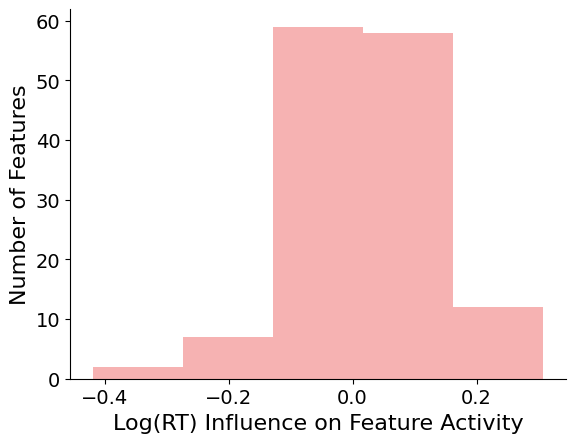

In [8]:
plt.hist(rt_activity_influence, bins=5, color='lightcoral', alpha=0.6)
plt.xlabel("Log(RT) Influence on Feature Activity")
plt.ylabel("Number of Features")

In [1]:
plt.scatter(feature_activities, rt_activity_influence, color='blue')
plt.xlabel("Mean Activity of Feature")
plt.ylabel("Log(RT) Influence on Feature Activity")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
np.corrcoef(feature_activities, rt_activity_influence)

import scipy.stats
pearsr_corr, p_value = scipy.stats.pearsonr(feature_activities, rt_activity_influence)
print(f"Pearson Correlation: {pearsr_corr}, p-value: {p_value}")
sspear_corr, p_value = scipy.stats.spearmanr(feature_activities, rt_activity_influence)
print(f"Spearman Correlation: {sspear_corr}, p-value: {p_value}")

NameError: name 'plt' is not defined

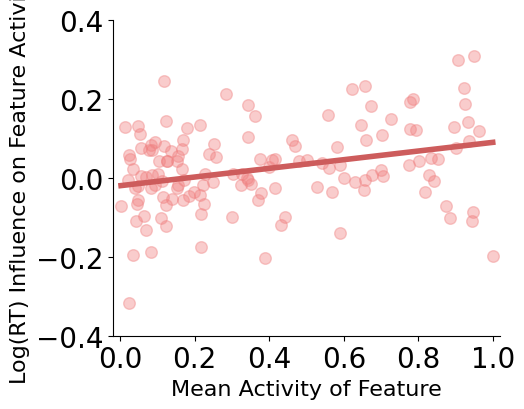

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Convert to arrays (just in case)
x = np.array(feature_activities)
y = np.array(rt_activity_influence)

# Add intercept
X = sm.add_constant(x)

# Fit OLS
model = sm.OLS(y, X).fit()

# Predicted line
x_line = np.linspace(x.min(), x.max(), 200)
X_line = sm.add_constant(x_line)
y_line = model.predict(X_line)

# Plot
plt.figure(figsize=(5,4))
plt.scatter(x, y, color='lightcoral', alpha=0.4, s=70)
plt.plot(x_line, y_line, color='indianred', linewidth=4)

plt.xlabel("Mean Activity of Feature")
plt.ylabel("Log(RT) Influence on Feature Activity")
# plt.grid(alpha=0.3)
plt.tight_layout()
plt.xlim(-0.02,1.02)
plt.xticks(fontsize=20)
plt.yticks([-0.4, -0.2, 0, 0.2, 0.4], fontsize=20)
plt.ylim(-0.4, 0.4)
plt.savefig("../plots/2F.pdf", bbox_inches="tight")
# print(model.summary())

In [ ]:
new_cols = {}
for col in feature_cols:
    new_col = f"{col}_switch"
    tmp = (data2.groupby('pid')[col].transform(lambda x: (x != x.shift()).astype(int)))
    tmp.loc[data2.groupby('pid').head(1).index] = np.nan
    new_cols[new_col] = tmp
data2 = pd.concat([data2, pd.DataFrame(new_cols, index=data2.index)], axis=1)

diff_dict = {}
for col in feature_cols:
    bin_col = f"{col}_switch"
    temp = data2.dropna(subset=[bin_col])
    logrt_diff = temp.groupby('pid').apply(lambda g: g.loc[g[bin_col] == 1, 'logRT'].mean() - g.loc[g[bin_col] == 0, 'logRT'].mean(), include_groups=False)  # Compute logRT difference per pid
    diff_dict[col] = logrt_diff
diff_df = pd.DataFrame(diff_dict)
# Optional: reset index if you want 'pid' as a column
# diff_df = diff_df.reset_index()

In [ ]:
# Plot
plt.figure(figsize=(4,3.5))
plt.hist(diff_df.sum(axis=1).values, color="indianred", alpha=0.6);
plt.ylabel("Num. participants")
plt.xlabel("log(RT) diff. (Switch - Stay)");

plt.figure(figsize=(4,3.5))
plt.hist(diff_df.sum(axis=0).values, color="lightcoral", alpha=0.6, bins=5);
plt.ylabel("Num. features")
plt.xlabel("log(RT) diff. (Switch - Stay)");
plt.savefig("../plots/2D.pdf", bbox_inches="tight")

In [ ]:
freqdict = json.load(open("../files/freq_abs_log.json", "r"))
data2["freq"] = data2["response"].map(freqdict)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you already computed log_likelihood and logRT
bins = np.linspace(data2["log_likelihood"].min(), data2["log_likelihood"].max(), 9)
data2["ll_bin"] = pd.cut(data2["log_likelihood"], bins=bins)

# Compute mean logRT per bin
mean_logRT = data2.groupby("ll_bin")["logRT"].mean()
bin_centers = [interval.mid for interval in mean_logRT.index]

# Plot scatter + mean trend
plt.scatter(data2["log_likelihood"], data2["logRT"], alpha=0.4, label="Individual points")
plt.plot(bin_centers, mean_logRT, color="red", marker="o", label="Mean logRT per bin")
plt.xlabel("Log Likelihood")
plt.ylabel("log(RT)")
plt.title("Log Likelihood vs log(RT)")
plt.ylim(-2, 6)
plt.legend()
plt.show()

In [ ]:
data2.columns

In [ ]:
Q1 = data2["RT"].quantile(0.25)
Q3 = data2["RT"].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for non-outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame
data2_no_outliers = data2[(data2["RT"] >= lower_bound) & (data2["RT"] <= upper_bound)]

In [ ]:
import numpy as np

data2 = data2.copy()
data2["logRT"] = np.log(data2["RT"])

Q1 = data2["logRT"].quantile(0.25)
Q3 = data2["logRT"].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

data2_no_outliers = data2[
    (data2["logRT"] >= lower) & (data2["logRT"] <= upper)
]

In [ ]:
data2_no_outliers = data2

In [ ]:
data2_no_outliers["RT"] = data2_no_outliers["RT"] + 0.001
data2_no_outliers["logRT"] = np.log(data2_no_outliers["RT"])
bin_edges = np.arange(
    data2_no_outliers["num_features_same"].min() + 10, 
    data2_no_outliers["num_features_same"].max(), 
    10
)
data2_no_outliers["bin"] = pd.cut(data2_no_outliers["num_features_same"], bins=bin_edges)
group_stats = data2_no_outliers.groupby("bin")["logRT"].agg(['mean', sem]).reset_index()
bin_centers = [interval.mid for interval in group_stats["bin"]]
plt.figure(figsize=(4,4))
plt.errorbar(
    bin_centers,
    group_stats["mean"],
    yerr=group_stats["sem"],
    fmt='o-',               # line with circle markers
    color='red',
    ecolor='black',         # color of error bars
    elinewidth=1,
    capsize=4
)
bin_labels = [f"{int(interval.left)}–{int(interval.right)}" for interval in group_stats["bin"]]
plt.xticks(ticks=bin_centers, labels=bin_labels, rotation=45)
plt.xlabel("Num. features same")
plt.ylabel("Mean log(RT)")
plt.tight_layout()
plt.show()

In [ ]:
data2_no_outliers["RT"] = data2_no_outliers["RT"] + 0.001
data2_no_outliers["logRT"] = np.log(data2_no_outliers["RT"])
data2_no_outliers["bin"] = pd.qcut(data2_no_outliers["num_features_same"], q=5)
group_stats = data2_no_outliers.groupby("bin")["logRT"].agg(['mean', sem]).reset_index()
x_positions = [ (interval.left + interval.right) / 2 for interval in group_stats["bin"] ]
bin_labels = [f"{int(interval.left)}–{int(interval.right)}" for interval in group_stats["bin"]]
plt.figure(figsize=(4, 4))
plt.errorbar(
    x_positions,
    group_stats["mean"],
    yerr=group_stats["sem"],
    fmt='o-',
    color='lightcoral',
    ecolor='black',
    elinewidth=1,
    capsize=4
)
plt.xticks(ticks=x_positions, labels=bin_labels, rotation=45)
plt.xlabel("Num. features same")
plt.ylabel("Mean log(RT)")
plt.tight_layout()
plt.savefig("../plots/2C.pdf")
plt.show();

In [ ]:
plt.hist(data2[data2["num_features_same"] > 122]["order"])

In [ ]:
plt.hist(data2[(data2["num_features_same"] > 117) & (data2["num_features_same"] < 122)]["order"])

In [ ]:
list(zip(data2[(data2["num_features_same"] < 122) & (data2["num_features_same"] > 117)]["response"], data2[(data2["num_features_same"] < 122) & (data2["num_features_same"] > 117)]["previous_response"]))

In [ ]:
list(zip(data2[data2["num_features_same"] > 122]["response"], data2[data2["num_features_same"] > 122]["previous_response"]))

In [ ]:
def get_num_features_same(df, featurecols):
    df['RT_diff_1back'] = np.nan  # Initialize the column with NaN
    df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols=featurecols)
    return df

def calculate_num_features_same(group, featurecols):
    group = group.reset_index(drop=True)
    
    num_features_same = np.full(len(group), np.nan)  # Initialize with NaN
    
    for i in range(1, len(group)):
        row1 = group.loc[i - 1, ["RT"]]
        row2 = group.loc[i, ["RT"]]

        # Check for NaN values
        if row1.isna().any() or row2.isna().any():
            num_features_same[i] = np.nan
        else:
            RTdiff = row2["RT"] - row1["RT"]
            num_features_same[i] = RTdiff
    
    group['RT_diff_1back'] = num_features_same  # Assign correctly
    return group

# Apply the function to your datasets
data2 = get_num_features_same(data2, vf_featurecols)

In [ ]:
def get_num_features_same(df, featurecols):
    df['RT_diff_2back'] = np.nan  # Initialize the column with NaN
    df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols=featurecols)
    return df

def calculate_num_features_same(group, featurecols):
    group = group.reset_index(drop=True)
    
    num_features_same = np.full(len(group), np.nan)  # Initialize with NaN
    
    for i in range(2, len(group)):
        row1 = group.loc[i - 2, ["RT"]]
        row2 = group.loc[i, ["RT"]]

        # Check for NaN values
        if row1.isna().any() or row2.isna().any():
            num_features_same[i] = np.nan
        else:
            RTdiff = row2["RT"] - row1["RT"]
            num_features_same[i] = RTdiff
    
    group['RT_diff_2back'] = num_features_same  # Assign correctly
    return group

data2 = get_num_features_same(data2, vf_featurecols)

In [ ]:
def get_num_features_same(df, featurecols):
    df['RT_diff_3back'] = np.nan  # Initialize the column with NaN
    df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols=featurecols)
    return df

def calculate_num_features_same(group, featurecols):
    group = group.reset_index(drop=True)
    
    num_features_same = np.full(len(group), np.nan)  # Initialize with NaN
    
    for i in range(3, len(group)):
        row1 = group.loc[i - 3, ["RT"]]
        row2 = group.loc[i, ["RT"]]

        # Check for NaN values
        if row1.isna().any() or row2.isna().any():
            num_features_same[i] = np.nan
        else:
            RTdiff = row2["RT"] - row1["RT"]
            num_features_same[i] = RTdiff
    
    group['RT_diff_3back'] = num_features_same  # Assign correctly
    return group

data2 = get_num_features_same(data2, vf_featurecols)

In [ ]:
def get_num_features_same(df, featurecols):
    df['RT_diff_4back'] = np.nan  # Initialize the column with NaN
    df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols=featurecols)
    return df

def calculate_num_features_same(group, featurecols):
    group = group.reset_index(drop=True)
    
    num_features_same = np.full(len(group), np.nan)  # Initialize with NaN
    
    for i in range(4, len(group)):
        row1 = group.loc[i - 4, ["RT"]]
        row2 = group.loc[i, ["RT"]]

        # Check for NaN values
        if row1.isna().any() or row2.isna().any():
            num_features_same[i] = np.nan
        else:
            RTdiff = row2["RT"] - row1["RT"]
            num_features_same[i] = RTdiff
    
    group['RT_diff_4back'] = num_features_same  # Assign correctly
    return group

data2 = get_num_features_same(data2, vf_featurecols)

In [ ]:
def get_num_features_same(df, featurecols):
    df['RT_diff_5back'] = np.nan  # Initialize the column with NaN
    df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols=featurecols)
    return df

def calculate_num_features_same(group, featurecols):
    group = group.reset_index(drop=True)
    
    num_features_same = np.full(len(group), np.nan)  # Initialize with NaN
    
    for i in range(5, len(group)):
        row1 = group.loc[i - 5, ["RT"]]
        row2 = group.loc[i, ["RT"]]

        # Check for NaN values
        if row1.isna().any() or row2.isna().any():
            num_features_same[i] = np.nan
        else:
            RTdiff = row2["RT"] - row1["RT"]
            num_features_same[i] = RTdiff
    
    group['RT_diff_5back'] = num_features_same  # Assign correctly
    return group

data2 = get_num_features_same(data2, vf_featurecols)

In [ ]:
def get_num_features_same(df, featurecols):
    df['RT_diff_0'] = np.nan  # Initialize the column with NaN
    df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols=featurecols)
    return df

def calculate_num_features_same(group, featurecols):
    group = group.reset_index(drop=True)
    
    num_features_same = np.full(len(group), np.nan)  # Initialize with NaN
    
    for i in range(0, len(group)):
        row1 = group.loc[i, ["RT"]]

        # Check for NaN values
        if row1.isna().any():
            num_features_same[i] = np.nan
        else:
            RTdiff = 0
            num_features_same[i] = RTdiff
    
    group['RT_diff_0'] = num_features_same  # Assign correctly
    return group

data2 = get_num_features_same(data2, vf_featurecols)

In [ ]:
def get_num_features_same(df, featurecols):
    df['RT_diff_1ahead'] = np.nan  # Initialize the column with NaN
    df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols=featurecols)
    return df

def calculate_num_features_same(group, featurecols):
    group = group.reset_index(drop=True)
    
    num_features_same = np.full(len(group), np.nan)  # Initialize with NaN
    
    for i in range(0, len(group) - 1):
        row1 = group.loc[i + 1, ["RT"]]
        row2 = group.loc[i, ["RT"]]

        # Check for NaN values
        if row1.isna().any() or row2.isna().any():
            num_features_same[i] = np.nan
        else:
            RTdiff = row2["RT"] - row1["RT"]
            num_features_same[i] = RTdiff
    
    group['RT_diff_1ahead'] = num_features_same  # Assign correctly
    return group

data2 = get_num_features_same(data2, vf_featurecols)

In [ ]:
def get_num_features_same(df, featurecols):
    df['RT_diff_2ahead'] = np.nan  # Initialize the column with NaN
    df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols=featurecols)
    return df

def calculate_num_features_same(group, featurecols):
    group = group.reset_index(drop=True)
    
    num_features_same = np.full(len(group), np.nan)  # Initialize with NaN
    
    for i in range(0, len(group) - 2):
        row1 = group.loc[i + 2, ["RT"]]
        row2 = group.loc[i, ["RT"]]

        # Check for NaN values
        if row1.isna().any() or row2.isna().any():
            num_features_same[i] = np.nan
        else:
            RTdiff = row2["RT"] - row1["RT"]
            num_features_same[i] = RTdiff
    
    group['RT_diff_2ahead'] = num_features_same  # Assign correctly
    return group

data2 = get_num_features_same(data2, vf_featurecols)

In [ ]:
# Calculate means and standard errors
means = [
    np.mean(data2["RT_diff_5back"]),
    np.mean(data2["RT_diff_4back"]),
    np.mean(data2["RT_diff_3back"]),
    np.mean(data2["RT_diff_2back"]),
    np.mean(data2["RT_diff_1back"]),
    np.mean(data2["RT_diff_0"]),
    np.mean(data2["RT_diff_1ahead"]),
    np.mean(data2["RT_diff_2ahead"])
]

std_errors = [
    np.std(data2["RT_diff_5back"], ddof=1) / np.sqrt(len(data2["RT_diff_5back"].dropna())),
    np.std(data2["RT_diff_4back"], ddof=1) / np.sqrt(len(data2["RT_diff_4back"].dropna())),
    np.std(data2["RT_diff_3back"], ddof=1) / np.sqrt(len(data2["RT_diff_3back"].dropna())),
    np.std(data2["RT_diff_2back"], ddof=1) / np.sqrt(len(data2["RT_diff_2back"].dropna())),
    np.std(data2["RT_diff_1back"], ddof=1) / np.sqrt(len(data2["RT_diff_1back"].dropna())),
    np.std(data2["RT_diff_0"], ddof=1) / np.sqrt(len(data2["RT_diff_0"].dropna())),
    np.std(data2["RT_diff_1ahead"], ddof=1) / np.sqrt(len(data2["RT_diff_1ahead"].dropna())),
    np.std(data2["RT_diff_2ahead"], ddof=1) / np.sqrt(len(data2["RT_diff_2ahead"].dropna()))
]

x_labels = [-5, -4, -3, -2, -1, 0, 1, 2]

# Plot bar chart with error bars
plt.figure(figsize=(8, 6))
plt.bar(x_labels, means, yerr=std_errors, capsize=5, alpha=0.7, color='mediumpurple')
plt.xlabel("Pos. wrt to most recent resp.")
plt.ylabel("Mean RT Difference")
plt.show()

# TSNE

In [ ]:
names = vf_featuredf.iloc[:, 0]            # First column = names
features = vf_featuredf.iloc[:, 1:]        # Rest = binary features
tsne = TSNE(n_components=2, perplexity=50, random_state=42, metric='hamming')
embedding = tsne.fit_transform(features)
plt.figure(figsize=(10, 7))
plt.scatter(embedding[:, 0], embedding[:, 1], s=50, alpha=0.5, c="mediumpurple")
plt.title("t-SNE of Binary Vectors")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(False)
plt.show()

# Feature Differences

In [ ]:
def has_two_chunks(lst):
    count = 0  # Count of contiguous chunks of ones with length > 1
    i = 0
    while i < len(lst):
        if lst[i] == 1:
            start = i
            while i < len(lst) and lst[i] == 1:
                i += 1
            if i - start > 1:
                count += 1
                if count >= 2:
                    return 1
        else:
            i += 1
    return 0

# Apply function to each feature_* column, grouped by 'pid'
returned_to_same_feature = {
    col: data2.groupby("pid")[col].apply(has_two_chunks) for col in vf_featurecols
}

# Convert results to DataFrame
returned_to_same_feature_df = pd.DataFrame(returned_to_same_feature)
returned = (np.sum(returned_to_same_feature_df, axis=0)/len(data2["pid"].unique())).to_dict()
returned = dict(sorted(returned.items(), key=lambda item: item[1]))
plt.figure(figsize=(3,30))
plt.barh(list(returned.keys()), list(returned.values()))
plt.xticks(rotation=90);

# Individual Differences

In [ ]:
#hierarchical modelling
hierarchical_fit = pk.load(open("../fits/hierarchical_fits_freqweightedhsactivity.pk", "rb"))
individual_params = hierarchical_fit["individual_params"]

In [ ]:
plt.hist(hierarchical_fit["sigma2"]);
plt.xlabel("Feature Group Var")
plt.ylabel("Num features")

In [ ]:
tsne = TSNE(
    n_components=2,
    perplexity=30,          # try 5–40 if you want to experiment
    learning_rate='auto',
    init='random',
    n_iter=1000,
    random_state=42
)
X_tsne = tsne.fit_transform(individual_params)

# Plot
plt.figure(figsize=(6,5))
sc = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=30, alpha=0.8, c=data2.groupby("pid").count()["response"].tolist(), cmap="Greens")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
# plt.title("t-SNE Visualization (141×277 → 2D)")
plt.tight_layout()
cbar = plt.colorbar(sc)
cbar.set_label("Num. responses")
plt.show()

In [ ]:
from scipy.stats import entropy
import statsmodels.api as sm
probs = np.exp(individual_params)               # exponentiate to make positive
probs = probs / probs.sum(axis=1, keepdims=True)  # normalize rows to sum to 1
row_entropies = entropy(probs, axis=1)  # shape (141,)
print(np.corrcoef(row_entropies, data2.groupby("pid").count()["response"].tolist()))
x = np.array(row_entropies)
y = np.array(data2.groupby("pid").count()["response"].tolist())
x_with_const = sm.add_constant(x)
model = sm.OLS(y, x_with_const).fit()
print(model.summary())
plt.hist(row_entropies);
plt.xlabel("Entropy of weights")
plt.ylabel("Num. participants")

In [ ]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# individual_params: shape (141, 277)

# Compute row-wise variance (or std)
row_variances = np.mean(individual_params, axis=1)   # or np.std(..., axis=1) for std
# row_stds = np.std(individual_params, axis=1)

# Response counts per PID
y = np.array(data2.groupby("pid").count()["response"].tolist())

# Correlation
print(np.corrcoef(row_variances, y))

# OLS regression
x = row_variances
x_with_const = sm.add_constant(x)
model = sm.OLS(y, x_with_const).fit()
print(model.summary())

# Optional: visualize
plt.hist(row_variances, bins=20, color='steelblue', edgecolor='black')
plt.xlabel("Row Variance")
plt.ylabel("Frequency")
plt.title("Distribution of Row-wise Variances")
plt.tight_layout()
plt.show()

In [ ]:
plt.hist(individual_params[3])
print(row_entropies[3])

In [ ]:
import re
log_text = """
Starting hierarchical MAP-EM fitting for 141 participants...
Running parallel E-step on 64 workers...
Iter 001 | Δμ=3.190698 | Time=97.12s
Running parallel E-step on 64 workers...
Iter 002 | Δμ=0.721679 | Time=91.87s
Running parallel E-step on 64 workers...
Iter 003 | Δμ=0.371508 | Time=90.42s
Running parallel E-step on 64 workers...
Iter 004 | Δμ=0.245130 | Time=89.41s
Running parallel E-step on 64 workers...
Iter 005 | Δμ=0.181792 | Time=90.03s
Running parallel E-step on 64 workers...
Iter 006 | Δμ=0.144091 | Time=87.23s
Running parallel E-step on 64 workers...
Iter 007 | Δμ=0.119237 | Time=86.67s
Running parallel E-step on 64 workers...
Iter 008 | Δμ=0.101666 | Time=85.17s
Running parallel E-step on 64 workers...
Iter 009 | Δμ=0.088722 | Time=86.54s
Running parallel E-step on 64 workers...
Iter 010 | Δμ=0.078539 | Time=85.11s
Running parallel E-step on 64 workers...
Iter 011 | Δμ=0.070305 | Time=83.08s
Running parallel E-step on 64 workers...
Iter 012 | Δμ=0.063829 | Time=85.09s
Running parallel E-step on 64 workers...
Iter 013 | Δμ=0.058258 | Time=86.29s
Running parallel E-step on 64 workers...
Iter 014 | Δμ=0.053594 | Time=85.48s
Running parallel E-step on 64 workers...
Iter 015 | Δμ=0.049716 | Time=83.68s
Running parallel E-step on 64 workers...
Iter 016 | Δμ=0.046371 | Time=86.04s
Running parallel E-step on 64 workers...
Iter 017 | Δμ=0.043390 | Time=84.20s
Running parallel E-step on 64 workers...
Iter 018 | Δμ=0.040813 | Time=83.71s
Running parallel E-step on 64 workers...
Iter 019 | Δμ=0.038580 | Time=83.62s
Running parallel E-step on 64 workers...
Iter 020 | Δμ=0.036423 | Time=86.33s
Running parallel E-step on 64 workers...
Iter 021 | Δμ=0.034517 | Time=84.29s
Running parallel E-step on 64 workers...
Iter 022 | Δμ=0.032910 | Time=84.96s
Running parallel E-step on 64 workers...
Iter 023 | Δμ=0.031488 | Time=84.62s
Running parallel E-step on 64 workers...
Iter 024 | Δμ=0.030089 | Time=83.73s
Running parallel E-step on 64 workers...
Iter 025 | Δμ=0.028700 | Time=82.34s
Running parallel E-step on 64 workers...
Iter 026 | Δμ=0.027672 | Time=85.24s
Running parallel E-step on 64 workers...
Iter 027 | Δμ=0.026705 | Time=83.74s
Running parallel E-step on 64 workers...
Iter 028 | Δμ=0.025878 | Time=84.12s
Running parallel E-step on 64 workers...
Iter 029 | Δμ=0.024755 | Time=86.20s
Running parallel E-step on 64 workers...
Iter 030 | Δμ=0.024071 | Time=85.77s
Running parallel E-step on 64 workers...
Iter 031 | Δμ=0.023323 | Time=84.26s
Running parallel E-step on 64 workers...
Iter 032 | Δμ=0.022700 | Time=84.38s
Running parallel E-step on 64 workers...
Iter 033 | Δμ=0.022190 | Time=82.28s
Running parallel E-step on 64 workers...
Iter 034 | Δμ=0.021500 | Time=83.43s
Running parallel E-step on 64 workers...
Iter 035 | Δμ=0.020997 | Time=83.25s
Running parallel E-step on 64 workers...
Iter 036 | Δμ=0.020491 | Time=81.97s
Running parallel E-step on 64 workers...
Iter 037 | Δμ=0.019983 | Time=83.18s
Running parallel E-step on 64 workers...
Iter 038 | Δμ=0.019475 | Time=85.03s
Running parallel E-step on 64 workers...
Iter 039 | Δμ=0.019016 | Time=83.65s
Running parallel E-step on 64 workers...
Iter 040 | Δμ=0.018715 | Time=83.47s
Running parallel E-step on 64 workers...
Iter 041 | Δμ=0.018322 | Time=85.35s
Running parallel E-step on 64 workers...
Iter 042 | Δμ=0.017987 | Time=83.98s
Running parallel E-step on 64 workers...
Iter 043 | Δμ=0.017787 | Time=83.26s
Running parallel E-step on 64 workers...
Iter 044 | Δμ=0.017404 | Time=84.28s
Running parallel E-step on 64 workers...
Iter 045 | Δμ=0.017183 | Time=83.57s
Running parallel E-step on 64 workers...
Iter 046 | Δμ=0.016902 | Time=83.56s
Running parallel E-step on 64 workers...
Iter 047 | Δμ=0.016660 | Time=83.79s
Running parallel E-step on 64 workers...
Iter 048 | Δμ=0.016344 | Time=84.49s
Running parallel E-step on 64 workers...
Iter 049 | Δμ=0.016198 | Time=85.90s
Running parallel E-step on 64 workers...
Iter 050 | Δμ=0.015996 | Time=84.24s
Running parallel E-step on 64 workers...
Iter 051 | Δμ=0.015812 | Time=85.99s
Running parallel E-step on 64 workers...
Iter 052 | Δμ=0.015560 | Time=85.69s
Running parallel E-step on 64 workers...
Iter 053 | Δμ=0.015504 | Time=84.36s
Running parallel E-step on 64 workers...
Iter 054 | Δμ=0.015160 | Time=85.09s
Running parallel E-step on 64 workers...
Iter 055 | Δμ=0.015176 | Time=84.97s
Running parallel E-step on 64 workers...
Iter 056 | Δμ=0.014997 | Time=84.97s
Running parallel E-step on 64 workers...
Iter 057 | Δμ=0.014831 | Time=84.24s
Running parallel E-step on 64 workers...
Iter 058 | Δμ=0.014761 | Time=83.77s
Running parallel E-step on 64 workers...
Iter 059 | Δμ=0.014497 | Time=86.50s
Running parallel E-step on 64 workers...
Iter 060 | Δμ=0.014405 | Time=86.21s
Running parallel E-step on 64 workers...
Iter 061 | Δμ=0.014338 | Time=84.77s
Running parallel E-step on 64 workers...
Iter 062 | Δμ=0.014233 | Time=86.10s
Running parallel E-step on 64 workers...
Iter 063 | Δμ=0.014107 | Time=85.43s
Running parallel E-step on 64 workers...
Iter 064 | Δμ=0.013974 | Time=86.55s
Running parallel E-step on 64 workers...
Iter 065 | Δμ=0.013859 | Time=84.73s
Running parallel E-step on 64 workers...
Iter 066 | Δμ=0.013799 | Time=85.33s
Running parallel E-step on 64 workers...
Iter 067 | Δμ=0.013705 | Time=85.67s
Running parallel E-step on 64 workers...
Iter 068 | Δμ=0.013658 | Time=84.51s
Running parallel E-step on 64 workers...
Iter 069 | Δμ=0.013602 | Time=84.34s
Running parallel E-step on 64 workers...
Iter 070 | Δμ=0.013466 | Time=85.08s
Running parallel E-step on 64 workers...
Iter 071 | Δμ=0.013387 | Time=85.66s
Running parallel E-step on 64 workers...
Iter 072 | Δμ=0.013261 | Time=84.85s
Running parallel E-step on 64 workers...
Iter 073 | Δμ=0.013217 | Time=85.39s
Running parallel E-step on 64 workers...
Iter 074 | Δμ=0.013238 | Time=84.46s
Running parallel E-step on 64 workers...
Iter 075 | Δμ=0.013038 | Time=85.22s
Running parallel E-step on 64 workers...
Iter 076 | Δμ=0.012930 | Time=85.03s
Running parallel E-step on 64 workers...
Iter 077 | Δμ=0.012921 | Time=85.80s
Running parallel E-step on 64 workers...
Iter 078 | Δμ=0.012912 | Time=86.33s
Running parallel E-step on 64 workers...
Iter 079 | Δμ=0.012811 | Time=87.81s
Running parallel E-step on 64 workers...
Iter 080 | Δμ=0.012743 | Time=88.37s
Running parallel E-step on 64 workers...
Iter 081 | Δμ=0.012688 | Time=85.01s
Running parallel E-step on 64 workers...
Iter 082 | Δμ=0.012604 | Time=85.53s
Running parallel E-step on 64 workers...
Iter 083 | Δμ=0.012583 | Time=86.26s
Running parallel E-step on 64 workers...
Iter 084 | Δμ=0.012496 | Time=86.60s
Running parallel E-step on 64 workers...
Iter 085 | Δμ=0.012475 | Time=86.22s
Running parallel E-step on 64 workers...
Iter 086 | Δμ=0.012411 | Time=86.89s
Running parallel E-step on 64 workers...
Iter 087 | Δμ=0.012310 | Time=85.89s
Running parallel E-step on 64 workers...
Iter 088 | Δμ=0.012328 | Time=86.55s
Running parallel E-step on 64 workers...
Iter 089 | Δμ=0.012259 | Time=85.53s
Running parallel E-step on 64 workers...
Iter 090 | Δμ=0.012128 | Time=85.95s
Running parallel E-step on 64 workers...
Iter 091 | Δμ=0.012071 | Time=85.61s
Running parallel E-step on 64 workers...
Iter 092 | Δμ=0.011969 | Time=88.47s
Running parallel E-step on 64 workers...
Iter 093 | Δμ=0.011973 | Time=86.36s
Running parallel E-step on 64 workers...
Iter 094 | Δμ=0.011922 | Time=86.12s
Running parallel E-step on 64 workers...
Iter 095 | Δμ=0.011852 | Time=85.00s
Running parallel E-step on 64 workers...
Iter 096 | Δμ=0.011807 | Time=85.66s
Running parallel E-step on 64 workers...
Iter 097 | Δμ=0.011796 | Time=84.63s
Running parallel E-step on 64 workers...
Iter 098 | Δμ=0.011699 | Time=86.89s
Running parallel E-step on 64 workers...
Iter 099 | Δμ=0.011526 | Time=84.86s
Running parallel E-step on 64 workers...
Iter 100 | Δμ=0.011509 | Time=84.95s
"""

iters = [int(i) for i in re.findall(r"Iter\s+(\d+)", log_text)]
deltas = [float(x) for x in re.findall(r"Δμ=([\d\.]+)", log_text)]

# Plot
plt.figure(figsize=(7,5))
plt.plot(iters, deltas, linewidth=2)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Change in μ", fontsize=12)
# plt.title("Change in μ Across Hierarchical MAP-EM Iterations", fontsize=13)
# plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
plt.hist(data2.groupby("pid").count()["response"].tolist())
plt.xlabel("Num. responses")
plt.ylabel("Num. participants")

In [ ]:
individual_params.shape

In [ ]:
plt.figure(figsize=(10, 6))
im = plt.imshow(individual_params, aspect='auto', cmap='viridis')
plt.colorbar(im, label="Feature Mean Value")
plt.xlabel("Feature index")
plt.ylabel("PID index")
plt.title("Heatmap of Participant Learned Weights")
plt.tight_layout()
plt.show()

In [ ]:
n_pids, n_features = 141, 277

# Base mean per feature (same for all PIDs)
feature_means = np.random.normal(0, 0.5, size=n_features)

# Feature-level standard deviations (how much each feature varies per PID)
feature_sds = np.abs(np.random.normal(0.2, 0.1, size=n_features))

# Each PID independently samples from the feature distribution
individual_params = np.random.normal(
    loc=feature_means,
    scale=feature_sds,
    size=(n_pids, n_features)
)
# Plot to verify variation
plt.figure(figsize=(10, 6))
im = plt.imshow(individual_params, aspect='auto', cmap='viridis')
plt.colorbar(im, label="Feature Mean Value")
plt.xlabel("Feature index")
plt.ylabel("PID index")
plt.title("Heatmap of Participant Learned Weights (No Personal Offset, With Variation)")
plt.tight_layout()
plt.show()


In [ ]:
# pk.dump(individual_params, open("../fits/random_individual_params_forsim.pk", "wb"))
individual_params_random = pk.load(open("../fits/random_individual_params_forsim.pk", "rb"))
individual_params_recovered = pk.load(open("../fits/hierarchical_fits_freqweightedhsactivity_hierarchicaltesting.pk", "rb"))["individual_params"]

In [ ]:
plt.figure(figsize=(10, 6))
im = plt.imshow(individual_params_random, aspect='auto', cmap='viridis')
plt.colorbar(im, label="Feature Mean Value")
plt.xlabel("Feature index")
plt.ylabel("PID index")
plt.title("Heatmap of Participant Learned Weights")
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
im = plt.imshow(individual_params_recovered, aspect='auto', cmap='viridis')
plt.colorbar(im, label="Feature Mean Value")
plt.xlabel("Feature index")
plt.ylabel("PID index")
plt.title("Heatmap of Participant Learned Weights")
plt.tight_layout()
plt.show()

In [ ]:
def plot_binary_features_heatmap(df, featurecols):
    pids = df["pid"].unique()
    cnt = 1
    for pid in pids:
        responses = df[df["pid"] == pid]["response"].values
        pid_data = df[df["pid"] == pid][featurecols].reset_index(drop=True)
        
        plt.figure(figsize=(25, len(pid_data) * 0.25))
        sns.heatmap(
            pid_data,
            cmap=sns.color_palette(["white", "mediumpurple"]),
            cbar=False,
            linewidths=0.5,
            linecolor='black'
        )
        plt.title(f"Binary Features Heatmap for PID {pid}")
        plt.gca().xaxis.tick_top()
        plt.xticks(ticks=np.arange(len(featurecols)) + 0.5, labels=featurecols, rotation=90)
        plt.yticks(ticks=np.arange(len(responses)) + 0.5, labels=responses, rotation=0)
        plt.show()
        
        if cnt == 10:
            break
        cnt += 1

In [ ]:
plot_binary_features_heatmap(data2, vf_featurecols)

In [ ]:
pid_grouped = data2.groupby("pid")[feature_cols].mean()
pid_mean_feat = pid_grouped.values  # shape (141, 138) in your case
pid_list = pid_grouped.index.to_list()

In [ ]:
data2.groupby("pid").count()["response"].values

In [ ]:
mean_vec = vf_featuredf[feature_cols].mean().values.astype(float)
pid_mean_feat_unbiased = pid_mean_feat - mean_vec

In [ ]:
plt.figure(figsize=(10, 6))
im = plt.imshow(pid_mean_feat_unbiased, aspect='auto', cmap='viridis')
plt.colorbar(im, label="Feature Mean Value")
plt.xlabel("Feature index")
plt.ylabel("PID index")
plt.title("Heatmap of Participant Mean Features")
plt.tight_layout()
plt.show()

In [ ]:
row_probs = pid_mean_feat / pid_mean_feat.sum(axis=1, keepdims=True)
row_entropies = entropy(row_probs, axis=1)
print(np.corrcoef(row_entropies, data2.groupby("pid").count()["response"].values))

In [ ]:
plt.hist(row_entropies)

In [ ]:
import numpy as np
import statsmodels.api as sm

y = data2.groupby("pid").count()["response"].values
X = row_entropies
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

In [ ]:
row_variances = np.var(pid_mean_feat_unbiased, axis=1)
y = data2.groupby("pid").count()["response"].values
X = row_variances
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

In [ ]:
import numpy as np
import statsmodels.api as sm

# Dependent variable
y = data2.groupby("pid").count()["response"].values

# Independent variables
X = np.column_stack([row_entropies, row_variances])  # shape: (141, 2)

# Add intercept term
X = sm.add_constant(X)

# Fit OLS model
model = sm.OLS(y, X).fit()

# Print summary
print(model.summary())

In [ ]:
arr = np.clip(pid_mean_feat_unbiased, 1e-12, None)
row_probs = arr / arr.sum(axis=1, keepdims=True)
row_entropies = entropy(row_probs, axis=1)
print(row_entropies.shape)  # (141,)
print(row_entropies)

In [ ]:
mean_vec = vf_featuredf[feature_cols].mean().values.reshape(1, -1)
combined = np.vstack([pid_mean_feat, mean_vec])
tsne = TSNE(
    n_components=2,
    perplexity=15,
    learning_rate='auto',
    init='pca',
    random_state=42,
    metric='hamming'
)
tsne_results = tsne.fit_transform(combined)
tsne_participants = tsne_results[:-1, :]
tsne_mean = tsne_results[-1, :]
plt.figure(figsize=(6, 5))
plt.scatter(tsne_participants[:, 0], tsne_participants[:, 1],
            c='indianred', alpha=0.7, s=30, label='Participants')
plt.scatter(tsne_mean[0], tsne_mean[1],
            c='black', s=80, marker='*', label='Uniform Mean')
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(6, 5))
plt.scatter(
    tsne_participants[:, 0],
    tsne_participants[:, 1],
    c='indianred', alpha=0.7, s=30, label='Participants'
)
plt.scatter(
    tsne_mean[0], tsne_mean[1],
    c='black', s=80, marker='*', label='Uniform Mean'
)

# --- Annotate each participant ---
for i, pid in enumerate(pid_list):
    plt.text(
        tsne_participants[i, 0],
        tsne_participants[i, 1],
        str(pid),
        fontsize=7,
        ha='center',
        va='center'
    )

plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
data2[data2["pid"].isin([592, 392, 578, 994, 692, 696, 398, 490, 790])].groupby("pid").agg(list)["response"].values

In [ ]:
data2[data2["pid"].isin([394, 575, 797, 896, 480, 381])].groupby("pid").agg(list)["response"].values